<a href="https://colab.research.google.com/github/kirubanath/AI-DS_learnings/blob/main/Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1 : Setting up NLP Pipeline and Text Classification

## June 13, 2023

Welcome to Lab 1 of our course on Natural Language Processing! In this lab you will learn to implement different text-preprocessing techniques commonly used for NLP tasks as well as implement a standard text-classification algorithm for categorizing different news articles.

We assume that you are familiar with `python` programming language, and its libraries like `numpy` and `pandas`. We will also make use of other libraries like `nltk` and `pytorch` in the assignment. Familiarity with these libraries is not assumed so we will provide short tutorials on their usage within the assignment.

Expected learning outcomes from this Lab include:
- Understand and implement text pre-processing techniques for NLP tasks
- Gain understanding of count / frequency based bag of word models for performing text classification
- Learn how to use Pytorch to define and train models for text classification

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    data_dir = "gdrive/MyDrive/PlakshaNLP2023/Lab1/data/ag_news_csv"
except:
    data_dir = "/home/t-kabirahuja/work/repos/PlakshaNLP/TLPNLP2023/source/Lab1/data/ag_news_csv"

Mounted at /content/gdrive


In [2]:
# Install required libraries
!pip install numpy
!pip install pandas
!pip install nltk
!pip install torch
!pip install tqdm
!pip install matplotlib
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# We start by importing libraries that we will be making use of in the lab.
import string
import tqdm
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download("punkt")
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## AG News Dataset

For the purposes of this lab we will be working with the [AG News](http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) topic classification dataset introduced in [Zhang et al. 2015](https://papers.nips.cc/paper_files/paper/2015/hash/250cf8b51c773f3f8dc8b4be867a9a02-Abstract.html). The dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600. The four classes correspond to the following:

- 1: World
- 2: Sports
- 3: Business
- 4: Sci/Tech


The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 3 columns in them, corresponding to class index (1 to 4), title and description. The title and description are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

We start by loading the datasets into memory.

In [4]:
NUM_LABELS = 4
LABELS_MAP = ["World", "Sports", "Business", "Sci/Tech"]

def load_dataset(split):
    ## Load the datasets and specify the column names
    df = pd.read_csv(f"{data_dir}/{split}.csv", names=["label", "title", "description"])

    ## Merge the title and description columns
    df["news"] = df["title"] + " " + df["description"]

    ## Remove the title and description columns
    df = df.drop(["title", "description"], axis=1)

    ## Have the labels start from 0
    df["label"] = df["label"] - 1

    ## Map the label to the corresponding class
    df["label_readable"] = df["label"].apply(lambda x: LABELS_MAP[int(x)])

    df = df[["news", "label", "label_readable"]]

    # Shuffle the dataset
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    return df

## Load the datasets and specify the column names
train_df = load_dataset("train")
test_df = load_dataset("test")

print(f"Number of Training Examples: {len(train_df)}")
print(f"Number of Test Examples: {len(test_df)}")

Number of Training Examples: 120000
Number of Test Examples: 7600


In [5]:
# View a sample of the dataset
train_df.head()

,news,label,label_readable
0,"BBC set for major shake-up, claims newspaper L...",2,Business
1,Marsh averts cash crunch Embattled insurance b...,2,Business
2,"Jeter, Yankees Look to Take Control (AP) AP - ...",1,Sports
3,Flying the Sun to Safety When the Genesis caps...,3,Sci/Tech
4,Stocks Seen Flat as Nortel and Oil Weigh NEW ...,2,Business


As can be seen from the sample of training dataset using `train_df.head()`, the dataframe contains columns `news`, `label` and `label_readable` containing the news and the category label respectively.

As part of some preliminary data analysis below we visualize the distribution of the labels in the dataset.

In [6]:
train_df['news'][0]

'BBC set for major shake-up, claims newspaper London - The British Broadcasting Corporation, the world #39;s biggest public broadcaster, is to cut almost a quarter of its 28 000-strong workforce, in the biggest shake-up in its 82-year history, The Times newspaper in London said on Monday.'

<Axes: xlabel='label_readable', ylabel='count'>

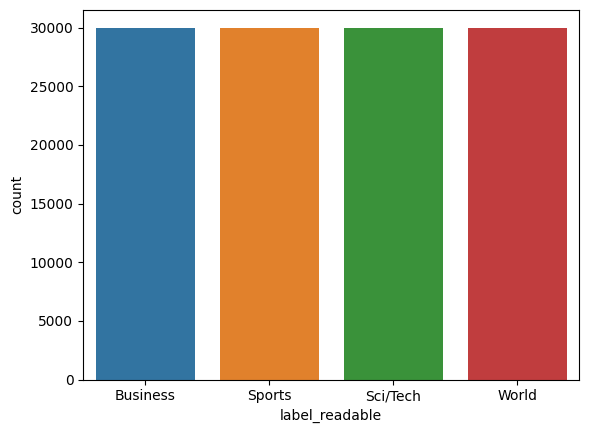

In [7]:
## Visualize the label distribution
sns.countplot(train_df, x = "label_readable")

As can be seen from the plot we have fully balaced training dataset with 30k points in each class

## Task 1: Preprocessing Pipeline for NLP (30 minutes)

You will start by implementing different text-preprocessing functions below. We have provided the definitions for the functions you are supposed to implement. After filling the code for the function, you can run the cell that follows to run test cases on your code.

### Task 1.1: Word Tokenization

Before we start preprocessing the text data and eventually training classification models, it is crucial to break the text into a set of constituents called tokens which can either be sentences, words, sub-words or characters. For the purposes of this assignment we will focus on Word Tokenization i.e. breaking a piece of text into a sequence of words.

There are different ways splitting a piece of text into a list of words. The simplest solution can be to split whenever a white-space character (i.e. `" "`) is encountered in the text i.e. if you have a string `"this is an example of tokenization"`, you iterate through it and whenever a white space is encountered you split the word to get: `["this", "is", "an", "example", "of", "tokenization"]`.

Implement the `whitespace_word_tokenize` function below

In [8]:
def whitespace_word_tokenize(text):
  """
  Splits a python string containing some text to a sequence of words
  by splitting on whitespace.

  Parameters:
    - text (str): A Python string containing the text to be tokenized

  Returns:
    - words (list): A list contaning the words present in the text (in the same order)

  """
  # words = None
  # YOUR CODE HERE
  words = text.split()
  # raise NotImplementedError()

  return words

In [9]:
def evaluate_list_test_cases(test_case_input,test_case_func_output,test_case_exp_output):

    print(f"Input: {test_case_input}")
    print(f"Function Output: {test_case_func_output}")
    print(f"Expected Output: {test_case_exp_output}")

    if test_case_func_output == test_case_exp_output:
        print("Test Case Passed :)")
        print("**********************************\n")
        return True
    else:
        print("Test Case Failed :(")
        print("**********************************\n")
        return False




print("Running Sample Test Cases")
print("Sample Test Case 1:")
test_case = "We all live in a Yellow Submarine"
test_case_answer = ['We', 'all', 'live', 'in', 'a', 'Yellow', 'Submarine']
test_case_student_answer = whitespace_word_tokenize(test_case)
assert evaluate_list_test_cases(test_case, test_case_student_answer, test_case_answer)

print("Sample Test Case 2:")
test_case = "We all live, in a Yellow Submarine."
test_case_answer = ['We', 'all', 'live,', 'in', 'a', 'Yellow', 'Submarine.']
test_case_student_answer = whitespace_word_tokenize(test_case)
assert evaluate_list_test_cases(test_case, test_case_student_answer, test_case_answer)


Running Sample Test Cases
Sample Test Case 1:
Input: We all live in a Yellow Submarine
Function Output: ['We', 'all', 'live', 'in', 'a', 'Yellow', 'Submarine']
Expected Output: ['We', 'all', 'live', 'in', 'a', 'Yellow', 'Submarine']
Test Case Passed :)
**********************************

Sample Test Case 2:
Input: We all live, in a Yellow Submarine.
Function Output: ['We', 'all', 'live,', 'in', 'a', 'Yellow', 'Submarine.']
Expected Output: ['We', 'all', 'live,', 'in', 'a', 'Yellow', 'Submarine.']
Test Case Passed :)
**********************************



As you can see from the outputs above the white space tokenizer does reasonably well in splitting a sentence into words. However, it is not perfect, as can be seen in the output of test case 2 this method fails to split words when punctuations are encountered which are retained as parts of the words like `"live,"` and `"Submarine."`.

One possible solution is to instead of splitting on the white-space also split when punctuations are encountered. This will partially solve the problem but there are certain other cases that still won't be handled properly by this, like we would want something like `"don't"` to be split into `["do", "n't"]` instead of `["don", "'", "t"]`.

Thankfully, nltk package provides the `word_tokenize` function that handles most of such cases inbuilt. Implement the `nltk_word_tokenize` function below which uses `word_tokenize` function from the nltk library to tokenize the text. Refer to the documentation [here](https://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.treebank) to understand the usage of `word_tokenize` function.

In [10]:
from nltk.tokenize import word_tokenize

In [11]:
def nltk_word_tokenize(text):
    """
    Splits a python string containing some text to a sequence of words
    by using `word_tokenize` function from nltk.
    Refer to https://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.treebank

    Parameters:
    - text (str): A Python string containing the text to be tokenized

    Returns:
    - words (list): A list contaning the words present in the text (in the same order)
    """

    # words = None

    # # YOUR CODE HERE
    # raise NotImplementedError()
    words = word_tokenize(text)

    return words

In [12]:
print("Running Sample Test Cases")
print("Sample Test Case 1:")
test_case = "We all live in a Yellow Submarine"
test_case_answer = ['We', 'all', 'live', 'in', 'a', 'Yellow', 'Submarine']
test_case_student_answer = nltk_word_tokenize(test_case)
assert evaluate_list_test_cases(test_case, test_case_student_answer, test_case_answer)

print("Sample Test Case 2:")
test_case = "We all live, in a Yellow Submarine."
test_case_answer = ['We', 'all', 'live', ',', 'in', 'a', 'Yellow', 'Submarine', '.']
test_case_student_answer = nltk_word_tokenize(test_case)
assert evaluate_list_test_cases(test_case, test_case_student_answer, test_case_answer)

print("Sample Test Case 3:")
test_case = "pi isn't a rational number and its approximate value is 3.14"
test_case_answer = ['pi', 'is', "n't", 'a', 'rational', 'number', 'and', 'its', 'approximate', 'value', 'is', '3.14']
test_case_student_answer = nltk_word_tokenize(test_case)
assert evaluate_list_test_cases(test_case, test_case_student_answer, test_case_answer)


Running Sample Test Cases
Sample Test Case 1:
Input: We all live in a Yellow Submarine
Function Output: ['We', 'all', 'live', 'in', 'a', 'Yellow', 'Submarine']
Expected Output: ['We', 'all', 'live', 'in', 'a', 'Yellow', 'Submarine']
Test Case Passed :)
**********************************

Sample Test Case 2:
Input: We all live, in a Yellow Submarine.
Function Output: ['We', 'all', 'live', ',', 'in', 'a', 'Yellow', 'Submarine', '.']
Expected Output: ['We', 'all', 'live', ',', 'in', 'a', 'Yellow', 'Submarine', '.']
Test Case Passed :)
**********************************

Sample Test Case 3:
Input: pi isn't a rational number and its approximate value is 3.14
Function Output: ['pi', 'is', "n't", 'a', 'rational', 'number', 'and', 'its', 'approximate', 'value', 'is', '3.14']
Expected Output: ['pi', 'is', "n't", 'a', 'rational', 'number', 'and', 'its', 'approximate', 'value', 'is', '3.14']
Test Case Passed :)
**********************************



As you can see (if your test cases passed), nltk does a much better job at splitting the text into constituent words, by splitting the punctuations away from the words as well as also taking care of subtleties like splitting `"isn't"` into `"is"` and `"n't"` and retaining the full decimal `"3.14"` which would have been split into `"3"` and `"14"` if we would have naively split on punctuations along with the whitespace.


### Task 1.2: Convert the text to lower case

We start the with the most basic of all text preprocessing techniques i.e. converting all the words in the text into lower case. As you will see soon, NLP models often treat different words as different entities and by default do not assume any relation between them. For eg. A word `Bat` will be treated differently from the word `bat` if we use them seperately to define the features. Hence it can be useful to remove such artifacts from the datasets so that we can have common representations for the same words.

Complete the function definiton below

In [13]:
def to_lower_case(text):
    """ Converts a piece of text to only contain words in lower case

    Parameters:
    - text (str): A Python string containing the text to be lower-cased

    Returns:
    - text_lower_case (str): A string containing the input text in lower case

    """

    # text_lower_case = None

    # # YOUR CODE HERE
    # raise NotImplementedError()

    text_lower_case = text.lower()

    return text_lower_case

In [14]:
"""Don't change code in this cell"""
#SAMPLE TEST CASE

def evaluate_string_test_cases(test_case_input,
                    test_case_func_output,
                    test_case_exp_output):

    print(f"Input: {test_case_input}")
    print(f"Function Output: {test_case_func_output}")
    print(f"Expected Output: {test_case_exp_output}")

    if test_case_func_output == test_case_exp_output:
        print("Test Case Passed :)")
        print("**********************************\n")
        return True
    else:
        print("Test Case Failed :(")
        print("**********************************\n")
        return False


print("Running Sample Test Cases")
print("Sample Test Case 1:")
test_case = "We all live in a Yellow Submarine"
test_case_answer = "we all live in a yellow submarine"
test_case_student_answer = to_lower_case(test_case)
assert evaluate_string_test_cases(test_case, test_case_student_answer, test_case_answer)

print("Sample Test Case 2:")
test_case = "SuRRender To The Void, iT is SHINNING"
test_case_answer = "surrender to the void, it is shinning"
test_case_student_answer = to_lower_case(test_case)
assert evaluate_string_test_cases(test_case, test_case_student_answer, test_case_answer)


Running Sample Test Cases
Sample Test Case 1:
Input: We all live in a Yellow Submarine
Function Output: we all live in a yellow submarine
Expected Output: we all live in a yellow submarine
Test Case Passed :)
**********************************

Sample Test Case 2:
Input: SuRRender To The Void, iT is SHINNING
Function Output: surrender to the void, it is shinning
Expected Output: surrender to the void, it is shinning
Test Case Passed :)
**********************************



### Task 1.3: Remove Punctuations

Another common way to reduce the number of word variations in the text like `hello` vs `hello,` is to remove punctuations. While for some NLP tasks like POS tagging punctuations might be helpful, for classification tasks punctuations can be assumed to have negligible effect on the actual label.

Complete the function `remove_punctuations` below. Examples for the function's working are:

| Input                                                                                                  | Expected Output                                                                                  |
|--------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal! | Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal |
| "Little tyke," chortled Mr. Dursley as he left the house.                                              | Little tyke chortled Mr Dursley as he left the house                                             |


In [15]:
def remove_punctuations(text):
    """
    Removes punctuations from a piece of text.

    Parameters:
    - text (str) : A Python string containing text from which punctuation is to be removed

    Returns:
    - text_no_punct (str): Resulting string after removing punctuation.

    Hint: You can use `string.punctuation` to get a string containing all punctuation symbols.
    >>> print(string.punctuation)
    '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

    """

    text_no_punct = ""

    for i in text:
      if i not in string.punctuation:
        text_no_punct+=i

    return text_no_punct

In [16]:
print("Running Sample Test Cases")
print("Sample Test Case 1:")
test_case = "Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal!"
test_case_answer = "Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal"
test_case_student_answer = remove_punctuations(test_case)
assert evaluate_string_test_cases(test_case, test_case_student_answer, test_case_answer)

print("Sample Test Case 2:")
test_case = "\"Little tyke,\" chortled Mr. Dursley as he left the house."
test_case_answer = "Little tyke chortled Mr Dursley as he left the house"
test_case_student_answer = remove_punctuations(test_case)
assert evaluate_string_test_cases(test_case, test_case_student_answer, test_case_answer)


Running Sample Test Cases
Sample Test Case 1:
Input: Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal!
Function Output: Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal
Expected Output: Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal
Test Case Passed :)
**********************************

Sample Test Case 2:
Input: "Little tyke," chortled Mr. Dursley as he left the house.
Function Output: Little tyke chortled Mr Dursley as he left the house
Expected Output: Little tyke chortled Mr Dursley as he left the house
Test Case Passed :)
**********************************



### Task 1.4: Remove Stop Words

There are some commonly used words in a language like in case of english 'the', 'a', 'I', 'he' which might not provide much valuable information for the current task in hand, and hence can be removed from the text. Again for a task like POS Tagging (which we will see in the future assignments), this shouldn't be done but for text classification the labels can be assumed to be largely independent of the presence of such words.

The choice of the stop words to use can be subjective and in many cases might depend upon the problem in hand. For the purposes of this assignment we will consider the stop words for English language present in the `nltk` package. The code for obtaining these stop words is given in the following cell.

In [17]:
from nltk.corpus import stopwords
STOPWORDS = stopwords.words("english")
",".join(STOPWORDS)

"i,me,my,myself,we,our,ours,ourselves,you,you're,you've,you'll,you'd,your,yours,yourself,yourselves,he,him,his,himself,she,she's,her,hers,herself,it,it's,its,itself,they,them,their,theirs,themselves,what,which,who,whom,this,that,that'll,these,those,am,is,are,was,were,be,been,being,have,has,had,having,do,does,did,doing,a,an,the,and,but,if,or,because,as,until,while,of,at,by,for,with,about,against,between,into,through,during,before,after,above,below,to,from,up,down,in,out,on,off,over,under,again,further,then,once,here,there,when,where,why,how,all,any,both,each,few,more,most,other,some,such,no,nor,not,only,own,same,so,than,too,very,s,t,can,will,just,don,don't,should,should've,now,d,ll,m,o,re,ve,y,ain,aren,aren't,couldn,couldn't,didn,didn't,doesn,doesn't,hadn,hadn't,hasn,hasn't,haven,haven't,isn,isn't,ma,mightn,mightn't,mustn,mustn't,needn,needn't,shan,shan't,shouldn,shouldn't,wasn,wasn't,weren,weren't,won,won't,wouldn,wouldn't"

As can be seen from the output above the stop words contain commonly used words that may not provide much information for the downstream task. Implement the function `remove_stop_words` below using the list of stop words given by `STOPWORDS` in the above cell.

Note that the stop words list contains the words in lower case, so you might want to convert a word in the text to lower case using `to_lower_case` function that you implemented above, before checking if it is present in the stop words list.

In [18]:
def remove_stop_words(text):
  STOPWORDS = stopwords.words("english")
  out = []
  text_split = nltk_word_tokenize(text)

  for t in text_split:
    if t.lower() not in STOPWORDS:
      out.append(t)

  return " ".join(out)

In [19]:
print("Running Sample Test Cases")
print("Sample Test Case 1:")
test_case = "Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal!"
test_case_answer = "Mr. Mrs. Dursley , number four , Privet Drive , proud say perfectly normal !"
test_case_student_answer = remove_stop_words(test_case)
assert evaluate_string_test_cases(test_case, test_case_student_answer, test_case_answer)



Running Sample Test Cases
Sample Test Case 1:
Input: Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal!
Function Output: Mr. Mrs. Dursley , number four , Privet Drive , proud say perfectly normal !
Expected Output: Mr. Mrs. Dursley , number four , Privet Drive , proud say perfectly normal !
Test Case Passed :)
**********************************



### Task 1.5: Stemming

It can be often benificial to group together different inflections of a word into a single term. For eg. *organizes* and *organizing* are the morphological inflections of the word *organize*, and replacing the instances of *organizes* and *organizing* with *organize* in our text data can help us reduce the number of unique words in our vocabulary. Stemming is one such approach to reduce the inflectional forms into a common base form.

One common way of performing steming over the words are the *Suffix Removal* algorithms, which involves removing certain suffixes from the word based on a pre-defined set of rules like:
- If the word ends with 's' remove 's' (denoted as S-> ϵ.eg. plays -> play)
- If the word ends with 'es' remove 'es' (denoted as ES-> ϵ. eg. mangoes -> mango).
- If the word ends with 'ing' remove 'ing'. (denoted as ING -> ϵ. eg. enjoying  -> enjoying)
- If the word ends with 'ly' remove 'ly'. (denoted as LY -> ϵ. eg. badly -> bad)

There can be much more similar rules defined to design a sophisticated stemmer. For now we would want you to implement a simple stemmer that uses only these 4 rules to stem words in a sentence. Complete the `stem_word` and `stem_text` functions below.

In [20]:
def stem_word(word):
    """
    Give a word performs suffix removal stemming on it using the following 4 rules:
    - S -> ϵ
    - ES -> ϵ
    - ING -> ϵ
    - LY -> ϵ
    If none of the four suffixes is to be found in the word, the it must be returned
    as it is.
    Parameters:
    - word (str) : A python string representing the word to stemmed

    Returns:
    - stemmed_word (str): `word` after stemming

    HINT: It is possible that two rules can be satisfied like for mangoes
    both the first two rules are satisfied i.e. it ends with 'es' as well as 's'
    In such cases consider the suffix with the larger length which is 'es'
    in this case.
    """

    stem_set = ['s','es','ing','ly']

    if len(word)>1 and word[-2:].lower() in stem_set:
      return word[:-2]
    elif len(word)>2 and word[-3:].lower() in stem_set:
      return word[:-3]
    elif word[-1].lower() == 's':
      return word[:-1]
    return word



def stem_text(text):
    """
    Stems all the words in a piece of text, by calling `stem_word` for each word.

    Parameters:
    - text (str): A Python string containing text whose words are to be stemmed.

    Returns:
    - stemmed_text (str) : Resulting string after stemming.

    HINT: You should use `nltk_word_tokenize` for splitting the text
        into words

    """

    out = []
    text_split = nltk_word_tokenize(text)

    for t in text_split:
      out.append(stem_word(t))


    return " ".join(out)


In [21]:
# Sample test cases for `stem_word`

print("Running Sample Test Cases")
print("Sample Test Case 1:")
test_case = "mangoes"
test_case_answer = "mango"
test_case_student_answer = stem_word(test_case)
assert evaluate_string_test_cases(test_case, test_case_student_answer, test_case_answer)

print("Sample Test Case 2:")
test_case = "plays"
test_case_answer = "play"
test_case_student_answer = stem_word(test_case)
assert evaluate_string_test_cases(test_case, test_case_student_answer, test_case_answer)

print("Sample Test Case 3:")
test_case = "enjoying"
test_case_answer = "enjoy"
test_case_student_answer = stem_word(test_case)
assert evaluate_string_test_cases(test_case, test_case_student_answer, test_case_answer)

print("Sample Test Case 4:")
test_case = "badly"
test_case_answer = "bad"
test_case_student_answer = stem_word(test_case)
assert evaluate_string_test_cases(test_case, test_case_student_answer, test_case_answer)

print("Sample Test Case 5:")
test_case = "fly"
test_case_answer = "f"
test_case_student_answer = stem_word(test_case)
assert evaluate_string_test_cases(test_case, test_case_student_answer, test_case_answer)

print("Sample Test Case 6:")
test_case = "connection"
test_case_answer = "connection"
test_case_student_answer = stem_word(test_case)
assert evaluate_string_test_cases(test_case, test_case_student_answer, test_case_answer)


Running Sample Test Cases
Sample Test Case 1:
Input: mangoes
Function Output: mango
Expected Output: mango
Test Case Passed :)
**********************************

Sample Test Case 2:
Input: plays
Function Output: play
Expected Output: play
Test Case Passed :)
**********************************

Sample Test Case 3:
Input: enjoying
Function Output: enjoy
Expected Output: enjoy
Test Case Passed :)
**********************************

Sample Test Case 4:
Input: badly
Function Output: bad
Expected Output: bad
Test Case Passed :)
**********************************

Sample Test Case 5:
Input: fly
Function Output: f
Expected Output: f
Test Case Passed :)
**********************************

Sample Test Case 6:
Input: connection
Function Output: connection
Expected Output: connection
Test Case Passed :)
**********************************



In [22]:
# Sample test cases for `stem_text`

print("Sample Test Case 1:")
test_case = "he sits and eats mangoes"
test_case_answer = "he sit and eat mango"
test_case_student_answer = stem_text(test_case)
assert evaluate_string_test_cases(test_case, test_case_student_answer, test_case_answer)

print("Sample Test Case 2:")
test_case = "he was badly hurt after playing"
test_case_answer = "he wa bad hurt after play"
test_case_student_answer = stem_text(test_case)
assert evaluate_string_test_cases(test_case, test_case_student_answer, test_case_answer)

print("Sample Test Case 3:")
test_case = "fly my little birds"
test_case_answer = "f my little bird"
test_case_student_answer = stem_text(test_case)
assert evaluate_string_test_cases(test_case, test_case_student_answer, test_case_answer)

print("Sample Test Case 4:")
test_case = "i am facing a poor network connection"
test_case_answer = "i am fac a poor network connection"
test_case_student_answer = stem_text(test_case)
assert evaluate_string_test_cases(test_case, test_case_student_answer, test_case_answer)


Sample Test Case 1:
Input: he sits and eats mangoes
Function Output: he sit and eat mango
Expected Output: he sit and eat mango
Test Case Passed :)
**********************************

Sample Test Case 2:
Input: he was badly hurt after playing
Function Output: he wa bad hurt after play
Expected Output: he wa bad hurt after play
Test Case Passed :)
**********************************

Sample Test Case 3:
Input: fly my little birds
Function Output: f my little bird
Expected Output: f my little bird
Test Case Passed :)
**********************************

Sample Test Case 4:
Input: i am facing a poor network connection
Function Output: i am fac a poor network connection
Expected Output: i am fac a poor network connection
Test Case Passed :)
**********************************



As can be seen above the toy stemmer that we just implemented is not perfect. It is limited to the 4 rules so misses some obvious cases like reducing *connection* to *connect* or sometimes can over stem the word like for the word *fly* above is stemmed to `f` which loses the meaning of the original word. The more sophisticated algorithms use a bunch of rules and heuristics to avoid such situations. One of the most commonly used stemming algorithm is `Porter Stemmer`, which uses a 5 step procedure involving different suffix removal as well as modification rules to perform stemming. Interested students can read more about how Porter Stemmer works from [here](https://vijinimallawaarachchi.com/2017/05/09/porter-stemming-algorithm/).

While implementing a sophisticated stemmer like Porter can be very complex, there are many python packages like *NLTK* (https://www.nltk.org/) that provide pre-implementations of a variety of stemming algorithms. Below we demonstrate how to implement `stem_word` function using different stemmers provided in NLTK.

In [23]:
# Importing the stemmers from NLTK
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer
def stem_word_with_nltk(word, stemmer_type = "porter"):

    """
    Stems a word using Porter Stemmer from NLTK
    - word (str) : A python string representing the word to be stemmed
    - stemmer_type (str) : The type of stemmer to be used - porter, lancaster or snowball

    Returns:
    - stemmed_word (str): `word` after stemming
    """

    # Initialize an object of the stemer class
    if stemmer_type == "porter":
        stemmer = PorterStemmer()
    elif stemmer_type == "lancaster":
        stemmer = LancasterStemmer()
    elif stemmer_type == "snowball":
        #Snowball stemmer works for multiple languages hence one should be specified during initialization
        stemmer = SnowballStemmer("english")
    else:
        stemmer = PorterStemmer()

    # Call the `stem` method
    stemmed_word = stemmer.stem(word)

    return stemmed_word

def stem_text_with_nltk(text, stemmer_type = "porter"):

    """
    Stems all the words in a piece of text using NLTK's stemers, by calling `stem_word_with_nltk` for each word.

    Parameters:
    - text (str): A Python string containing text whose words are to be stemmed.
    - stemmer_type (str) : The type of stemmer to be used - porter, lacaster or snowball

    Returns:
    - stemmed_text (str) : Resulting string after stemming.


    """

    stemmed_text = None

    stemmed_text = " ".join([stem_word_with_nltk(word,stemmer_type) for word in nltk_word_tokenize(text)])

    return stemmed_text

In [24]:
input = "connection"
porter_output = stem_word_with_nltk(input, "porter")
lancester_output = stem_word_with_nltk(input, "lancaster")
snowball_output = stem_word_with_nltk(input, "snowball")

print(f"Input: {input}")
print(f"Porter Stemmer Output: {porter_output}")
print(f"Lancaster Stemmer Output: {lancester_output}")
print(f"Snowball Stemmer Output: {snowball_output}")

print("*******************************************\n")

input = "fly"
porter_output = stem_word_with_nltk(input, "porter")
lancester_output = stem_word_with_nltk(input, "lancaster")
snowball_output = stem_word_with_nltk(input, "snowball")

print(f"Input: {input}")
print(f"Porter Stemmer Output: {porter_output}")
print(f"Lancaster Stemmer Output: {lancester_output}")
print(f"Snowball Stemmer Output: {snowball_output}")

print("*******************************************\n")


input = "happiness"
porter_output = stem_word_with_nltk(input, "porter")
lancester_output = stem_word_with_nltk(input, "lancaster")
snowball_output = stem_word_with_nltk(input, "snowball")

print(f"Input: {input}")
print(f"Porter Stemmer Output: {porter_output}")
print(f"Lancaster Stemmer Output: {lancester_output}")
print(f"Snowball Stemmer Output: {snowball_output}")

print("*******************************************\n")


input = "operational"
porter_output = stem_word_with_nltk(input, "porter")
lancester_output = stem_word_with_nltk(input, "lancaster")
snowball_output = stem_word_with_nltk(input, "snowball")

print(f"Input: {input}")
print(f"Porter Stemmer Output: {porter_output}")
print(f"Lancaster Stemmer Output: {lancester_output}")
print(f"Snowball Stemmer Output: {snowball_output}")

Input: connection
Porter Stemmer Output: connect
Lancaster Stemmer Output: connect
Snowball Stemmer Output: connect
*******************************************

Input: fly
Porter Stemmer Output: fli
Lancaster Stemmer Output: fly
Snowball Stemmer Output: fli
*******************************************

Input: happiness
Porter Stemmer Output: happi
Lancaster Stemmer Output: happy
Snowball Stemmer Output: happi
*******************************************

Input: operational
Porter Stemmer Output: oper
Lancaster Stemmer Output: op
Snowball Stemmer Output: oper


As can be seen these stemmers are able to recognize various types of cases for stemming and can do a better job than our toy implementation. However, even these stemmers tend to make errors, like *operational* is reduced to *op* by Lancaster stemmer. This is because in the end stemming algorithms just use a bunch of heuristics to reduce the inflectional forms without any proper morphological analysis.

**Lemmatization** is another common technique used to reduce different forms of a word to a common term called *lemma*, which makes use of a pre-defined vocabulary and morphological analysis of the words. Lemmatizers often work better when supplied with *Part of Speech tags* which we will be covering in the future assignments, so we will revisit Lemmatization later.

### Task 1.6: Combine all preprocessing functions to a single pipeline

Now that we are done implementing the main preprocessing functions that might be useful for a text classification task, we can combine them into a single function that applies these 4 preprocessing techniques over a piece of text. We will then use this function to preprocess the new articles in our training and dev datasets.

Implement the `preprocess_pipeline` and `preprocess_agnews_data` functions below, where the former function combines the 4 preprocessing functions implemented above and the latter applies that to all the news articles in the dataset.

Note: The order in which different preprocessing functions are to be applied can lead to different results. For eg. all of our stop words are in lower case hence before we remove them from the text we must make sure we have converted the text to lower case before hand. Please follow the following order for applying the preprocessing functions in your code:

  1. to_lower_case
  2. remove_punctuations
  3. remove_stop_words
  4. stem_text_with_nltk (call this with `stemer_type = "porter"`)

In [25]:
def preprocess_pipeline(text):

    """
    Given a piece of text applies preprocessing techniques
    like converting to lower case, removing stop words and punctuations,
    and stemming.

    Apply the functions in the following order:
    1. to_lower_case
    2. remove_punctuations
    3. remove_stop_words
    4. stem_text_with_nltk (call this with `stemer_type = "porter"`)

    Inputs:
    - text (str) : A python string containing text to be pre-processed

    Returns:
    - text_preprocessed (str) : Resulting string after applying preprocessing
    """
    text = to_lower_case(text)
    text = remove_punctuations(text)
    text = remove_stop_words(text)
    text = stem_text_with_nltk(text)


    return text

In [26]:
print("Running Sample Test Cases")
print("Sample Test Case 1:")
test_case = "Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal!"
test_case_answer = "mr mr dursley number four privet drive proud say perfectli normal"
test_case_student_answer = preprocess_pipeline(test_case)
assert evaluate_string_test_cases(test_case, test_case_student_answer, test_case_answer)

print("Sample Test Case 2:")
test_case = "\"Little tyke,\" chortled Mr. Dursley as He left the house."
test_case_answer = "littl tyke chortl mr dursley left hous"
test_case_student_answer = preprocess_pipeline(test_case)
assert evaluate_string_test_cases(test_case, test_case_student_answer, test_case_answer)


Running Sample Test Cases
Sample Test Case 1:
Input: Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal!
Function Output: mr mr dursley number four privet drive proud say perfectli normal
Expected Output: mr mr dursley number four privet drive proud say perfectli normal
Test Case Passed :)
**********************************

Sample Test Case 2:
Input: "Little tyke," chortled Mr. Dursley as He left the house.
Function Output: littl tyke chortl mr dursley left hous
Expected Output: littl tyke chortl mr dursley left hous
Test Case Passed :)
**********************************



In [27]:
def preprocess_agnews_data(df):
    """
    Takes the pandas dataframe containing ag_news data as input and applies
    the `preprocess_pipeline` function to the its sentence column.

    Inputs:
    - df (pd.DataFrame): A pandas dataframe containing the SST-2 data with format:
        | news      | label  | label_readable |
        ---------------------------------------
        | news_1    | label_1| label_1_readable|
        | news_2    | label_2| label_2_readable|
        | ..........| .......|. ...............|
        | ..........| .......|. ...............|

    Returns (pd.DataFrame):
    - df_preprocessed: Resulting dataframe after applying `preprocessing_pipeline`
    to the `sentence` column. Note that the column names of df_preprocessed
    should be same as df and its should have the same number of rows as `df`.


    Hint: Look up how to use `pd.DataFrame.apply` method in pandas

    """

    df_preprocessed = df.copy()
    df_preprocessed['news'] = df_preprocessed['news'].apply(preprocess_pipeline)


    return df_preprocessed


In [28]:
# Preprocess the train and test sets. This might take a few minutes
train_df_preprocessed = preprocess_agnews_data(train_df)
test_df_preprocessed = preprocess_agnews_data(test_df)
print(train_df_preprocessed.head())
print("***************************")
print(test_df_preprocessed.head())


                                                news  label label_readable
0  bbc set major shakeup claim newspap london bri...      2       Business
1  marsh avert cash crunch embattl insur broker 3...      2       Business
2  jeter yanke look take control ap ap derek jete...      1         Sports
3  fli sun safeti genesi capsul come back earth s...      3       Sci/Tech
4  stock seen flat nortel oil weigh new york reut...      2       Business
***************************
                                                news  label label_readable
0  fan v fan manchest citytottenham hotspur weeke...      1         Sports
1  pari tourist search key da vinci code reuter r...      0          World
2  net firm dont tax voip spanishamerican war tem...      3       Sci/Tech
3  depend speci risk extinct global extinct crisi...      3       Sci/Tech
4  ed charter member siebel bpo allianc newsfacto...      3       Sci/Tech


In [29]:
print("Running Sample Test Cases")
print("Sample Test Case 1: Checking if the object returned is a pandas Dataframe")
assert isinstance(train_df_preprocessed, pd.DataFrame)
print("Test Case Passed :)")
print("***********************************\n")

print("Sample Test Case 2: Checking if the returned dataframe has correct columns")
student_column_names = sorted(list(train_df_preprocessed.columns))
expected_column_names = ["label", "label_readable", "news"]

assert student_column_names == expected_column_names
print("Test Case Passed :)")
print("***********************************\n")

print("Sample Test Case 3: Checking if the number of rows of the returned dataframe is same as the original dataframes")
assert len(train_df) == len(train_df_preprocessed) and len(test_df) == len(test_df_preprocessed)
print("Test Case Passed :)")
print("***********************************\n")
print("Sample Test Case 4: Checking if the returned dataframe has sentences preprocessed")

student_output = train_df_preprocessed["news"].values[1]
expected_output = "marsh avert cash crunch embattl insur broker 39 bank agre waiv claus may prevent access credit new york reuter marsh amp mclennan co"
assert evaluate_string_test_cases(train_df["news"].values[1], student_output, expected_output)


Running Sample Test Cases
Sample Test Case 1: Checking if the object returned is a pandas Dataframe
Test Case Passed :)
***********************************

Sample Test Case 2: Checking if the returned dataframe has correct columns
Test Case Passed :)
***********************************

Sample Test Case 3: Checking if the number of rows of the returned dataframe is same as the original dataframes
Test Case Passed :)
***********************************

Sample Test Case 4: Checking if the returned dataframe has sentences preprocessed
Input: Marsh averts cash crunch Embattled insurance broker #39;s banks agree to waive clause that may have prevented access to credit. NEW YORK (Reuters) - Marsh  amp; McLennan Cos.
Function Output: marsh avert cash crunch embattl insur broker 39 bank agre waiv claus may prevent access credit new york reuter marsh amp mclennan co
Expected Output: marsh avert cash crunch embattl insur broker 39 bank agre waiv claus may prevent access credit new york reuter 

## Task 2: Bag Of Word Models for Text Classification (45 minutes)

Now that we are done with preprocessing the news articles in our datasets, we can begin building a classifier to classify the articles into topics.

As you might have studied in your Machine Learning courses, typical ML models work on the data described using mathematical objects like vectors and matrices, which are often referred to as features. These features can be of different types depending upon the downstream application, like for building a classifier to predict whether to give credit to a customer we might consider features like their age, income, employement status etc. In the same way to build a classifier for textual data, we need a way to describe each text example in terms of numeric features which can then be fed to the classification algorithm of our choice.

Bag of Words model is one of the simplest but surprisingly effective way to represent text data for building Machine Learning models. In bag of words, occurence (or frequency) of each word in a given text example is defined as a feature for training the classifier. The order in which these words occur in the text is not relevant and we are just concerned with which words are present in the text. Consider the following example to understand how bag of words are used to represent text.

As an example consider we have 2 examples present in our dataset:

x1: john likes to watch movies mary likes movies too

x2: mary also likes to watch football games

Based on these two documents we can get the list of all words that occur in this dataset which will be:

| index | word     |
|-------|----------|
| 0     | also     |
| 1     | football |
| 2     | games    |
| 3     | john     |
| 4     | likes    |
| 5     | mary     |
| 6     | movies   |
| 7     | to       |
| 8     | too      |
| 9     | watch    |

We can then define features for the two x1 and x2 as follows:


|    | also | football | games | john | likes | mary | movies | to | too | watch |
|----|------|----------|-------|------|-------|------|--------|----|-----|-------|
| x1 | 0    | 0        | 0     | 1    | 2     | 1    | 2      | 1  | 2   | 1     |
| x2 | 1    | 1        | 1     | 0    | 1     | 1    | 0      | 0  | 0   | 0     |

These features can then be used to train an ML model. To summarize the following two steps must be followed to create bag of word representations of the text examples in a dataset.

- Step 1: Create a word vocabulary by iterating through all the documents in the **training** dataset, storing all the unique words that are present in each document. Also maintain mappings to map each word to an index and vice-versa, which we will need to define values for each feature dimension.

- Step 2: For each document in the training and test sets, get the frequency of each word in our vocabulary and use it to define feature for that example.

Below you will implement functions to create bag of words representations of the dataset examples




### Task 2.1: Create vocabularies

As described above our first step will be to create word vocabulary for the documents in our dataset. Implement `create_vocab` function below which takes as input a list of documents and creates a list of unique words that occur in them.

In [30]:
def create_vocab(documents):
    """
    Given a list of documents each represented as a string,
    create a word vocabulary containing all the words that occur
    in these documents.

    Inputs:
    - documents (list) : A list with each element as a string representing a
    document.

    Returns:
    - vocab (list) : A **sorted** list containing all unique words in the
    documents

    Example Input: ['john likes to watch movies mary likes movies too',
                  'mary also likes to watch football games']

    Expected Output: ['also',
                    'football',
                    'games',
                    'john',
                    'likes',
                    'mary',
                    'movies',
                    'to',
                    'too',
                    'watch']


    Hint: `nltk_word_tokenize` function may come in handy

    """

    vocab = []
    for text in documents:
      vocab.extend(word_tokenize(text))

    return sorted(set(vocab)) # Don't change this

In [31]:


print("Running Sample Test Cases")
print("Sample Test Case 1:")

test_case = ["john likes to watch movies mary likes movies too",
              "mary also likes to watch football games"]
test_case_answer = ['also', 'football', 'games', 'john', 'likes', 'mary', 'movies', 'to', 'too', 'watch']
test_case_student_answer = create_vocab(test_case)
assert evaluate_list_test_cases(test_case, test_case_student_answer, test_case_answer)

print("Sample Test Case 2:")

test_case = ["We all live in a yellow submarine.",
             "Yellow submarine, yellow submarine!!"
             ]
test_case_answer = ['!', ',', '.', 'We', 'Yellow', 'a', 'all', 'in', 'live', 'submarine', 'yellow']
test_case_student_answer = create_vocab(test_case)
assert evaluate_list_test_cases(test_case, test_case_student_answer, test_case_answer)



Running Sample Test Cases
Sample Test Case 1:
Input: ['john likes to watch movies mary likes movies too', 'mary also likes to watch football games']
Function Output: ['also', 'football', 'games', 'john', 'likes', 'mary', 'movies', 'to', 'too', 'watch']
Expected Output: ['also', 'football', 'games', 'john', 'likes', 'mary', 'movies', 'to', 'too', 'watch']
Test Case Passed :)
**********************************

Sample Test Case 2:
Input: ['We all live in a yellow submarine.', 'Yellow submarine, yellow submarine!!']
Function Output: ['!', ',', '.', 'We', 'Yellow', 'a', 'all', 'in', 'live', 'submarine', 'yellow']
Expected Output: ['!', ',', '.', 'We', 'Yellow', 'a', 'all', 'in', 'live', 'submarine', 'yellow']
Test Case Passed :)
**********************************



Note the output of sample test case 2 contains punctuations as well as different upper-case and lower-case variants of a word detected as seperate words. This illustrates the importance of performing the preprocessing over the documents as it reduces the unnecessary words like punctuations, stop words in the vocablary as well as help provide a common term to different variants of a word. To illustrate this further, we create vocabulary without performing preprocessing and with pre-procesing below:

In [32]:
# Let's create vocabulary for the ag_news dataset without pre-processing

train_documents = train_df["news"].values.tolist()
train_vocab = create_vocab(train_documents)

print(f"Training Vocabulary Created. Number of words: {len(train_vocab)}")

Training Vocabulary Created. Number of words: 124673


124k words! This means we will be having 124k features for each document. Note that our training data has 120k documents, hence we can easily run into overfitting (Remember your ML class!) if we consider this vocabulary. Let's see how much applying the pre-processing helps in reducing the number of features:

In [33]:
# Let's create vocabulary for the ag_news dataset with pre-processing

train_documents = train_df_preprocessed["news"].values.tolist() # Note that we are selecting preprocessed documents
train_vocab = create_vocab(train_documents)

print(f"Training Vocabulary Created. Number of words: {len(train_vocab)}")

Training Vocabulary Created. Number of words: 81056


81k is definitely much better than 124k. However, this can result in large computational cost for training these models and also a possibility of overfitting! One other simple way to reduce the vacabulary is to remove tokens that appear very rarely in the corpus. Implement the function `create_vocab_w_rare_word_filter` below that does that:

In [34]:
from collections import Counter

In [35]:
def create_vocab_w_rare_word_filter(documents, threshold):

    """
    Given a list of documents each represented as a string,
    create a word vocabulary containing all the words that occur
    more than `threshold` times in these documents.

    Inputs:
    - documents (list) : A list with each element as a string representing a
    document.
    - threshold (int) : A threshold value to filter out rare words

    Returns:
    - vocab (list) : A **sorted** list containing all unique words in the
    documents

    Example Input: corpus = ['john likes to watch movies mary likes movies too',
                  'mary also likes to watch football games']
                  threshold = 1

    Expected Output: ['likes', 'mary', 'movies', 'to', 'watch']


    Hint:  collections.Counter might come handy

    """
    vocab = []

    for text in documents:
      vocab.extend(word_tokenize(text))

    counts = Counter(vocab)
    vocab = sorted(set(vocab))

    vocab = [x for x in vocab if counts[x] > threshold]


    return sorted(vocab) # Don't change this

In [36]:
print("Running Sample Test Cases")
print("Sample Test Case 1:")

test_case = ["john likes to watch movies mary likes movies too",
              "mary also likes to watch football games"]
test_case_answer = ['likes', 'mary', 'movies', 'to', 'watch']
test_case_student_answer = create_vocab_w_rare_word_filter(test_case, threshold=1)
assert evaluate_list_test_cases(test_case, test_case_student_answer, test_case_answer)

print("Sample Test Case 2:")

test_case = ["john likes to watch movies mary likes movies too",
              "mary also likes to watch football games"]
test_case_answer = ['likes']
test_case_student_answer = create_vocab_w_rare_word_filter(test_case, threshold=2)
assert evaluate_list_test_cases(test_case, test_case_student_answer, test_case_answer)



Running Sample Test Cases
Sample Test Case 1:
Input: ['john likes to watch movies mary likes movies too', 'mary also likes to watch football games']
Function Output: ['likes', 'mary', 'movies', 'to', 'watch']
Expected Output: ['likes', 'mary', 'movies', 'to', 'watch']
Test Case Passed :)
**********************************

Sample Test Case 2:
Input: ['john likes to watch movies mary likes movies too', 'mary also likes to watch football games']
Function Output: ['likes']
Expected Output: ['likes']
Test Case Passed :)
**********************************



In [37]:
# Let's create a vocabulary with words that appear more than 5 times in the training set

threshold = 5
train_documents = train_df_preprocessed["news"].values.tolist() # Note that we are selecting preprocessed documents
train_vocab = create_vocab_w_rare_word_filter(train_documents, threshold=threshold)

print(f"Training Vocabulary Created. Number of words: {len(train_vocab)}")

Training Vocabulary Created. Number of words: 19939


Now we have ~20k words in our vocabulary which is much more manageable

### Task 2.2: Create word to index mapping
Now that we have a list of words in our dataset, we can map each word to an index which will be useful to represent what word each feature dimension refers to. Implement the `get_word_idx_mapping` function below:

In [38]:
def get_word_idx_mapping(vocab):

    """
    Give a list of strings each representing a word in the vocabulary
    creates a dictionary that maps each word in the list to its
    corresponding index.

    Inputs:
    - vocab (list): A list of strings each representing a word in the vocabulary

    Outputs:
    - word2idx (dict): A Python dictionary mapping each word to its index in vocabulary

    Example Input: ['also',
                    'football',
                    'games',
                    'john',
                    'likes',
                    'mary',
                    'movies',
                    'to',
                    'too',
                    'watch']

    Expected Output: {'also': 0,
                  'football': 1,
                  'games': 2,
                  'john': 3,
                  'likes': 4,
                  'mary': 5,
                  'movies': 6,
                  'to': 7,
                  'too': 8,
                  'watch': 9}

    """

    word2idx = {y:x for x,y in enumerate(vocab)}
    return word2idx

In [39]:
print("Running Sample Test Cases")
print("Sample Test Case 1:")
test_case = ['also', 'football', 'games', 'john', 'likes', 'mary', 'movies', 'to', 'too', 'watch']
test_case_answer = {'also': 0, 'football': 1, 'games': 2, 'john': 3, 'likes': 4, 'mary': 5, 'movies': 6, 'to': 7, 'too': 8, 'watch': 9}
test_case_student_answer = get_word_idx_mapping(test_case)
assert evaluate_list_test_cases(test_case, test_case_student_answer, test_case_answer)



Running Sample Test Cases
Sample Test Case 1:
Input: ['also', 'football', 'games', 'john', 'likes', 'mary', 'movies', 'to', 'too', 'watch']
Function Output: {'also': 0, 'football': 1, 'games': 2, 'john': 3, 'likes': 4, 'mary': 5, 'movies': 6, 'to': 7, 'too': 8, 'watch': 9}
Expected Output: {'also': 0, 'football': 1, 'games': 2, 'john': 3, 'likes': 4, 'mary': 5, 'movies': 6, 'to': 7, 'too': 8, 'watch': 9}
Test Case Passed :)
**********************************



In [40]:
train_vocab2idx = get_word_idx_mapping(train_vocab)
train_vocab2idx

{'0': 0,
 '00': 1,
 '000': 2,
 '01': 3,
 '02': 4,
 '025': 5,
 '03': 6,
 '038': 7,
 '04': 8,
 '04ltstronggt': 9,
 '05': 10,
 '06': 11,
 '069': 12,
 '07': 13,
 '08': 14,
 '09': 15,
 '1': 16,
 '10': 17,
 '100': 18,
 '1000': 19,
 '10000': 20,
 '100000': 21,
 '10000m': 22,
 '1000th': 23,
 '1001': 24,
 '1005': 25,
 '100gb': 26,
 '100m': 27,
 '100meter': 28,
 '100metr': 29,
 '100million': 30,
 '100th': 31,
 '100yard': 32,
 '101': 33,
 '1010': 34,
 '1015': 35,
 '10189': 36,
 '102': 37,
 '1025': 38,
 '10294': 39,
 '103': 40,
 '1030': 41,
 '10393': 42,
 '10397': 43,
 '104': 44,
 '10496': 45,
 '105': 46,
 '1050': 47,
 '106': 48,
 '1066mhz': 49,
 '107': 50,
 '1070': 51,
 '107101': 52,
 '107102': 53,
 '108': 54,
 '109': 55,
 '10bn': 56,
 '10day': 57,
 '10g': 58,
 '10game': 59,
 '10k': 60,
 '10m': 61,
 '10man': 62,
 '10member': 63,
 '10million': 64,
 '10month': 65,
 '10race': 66,
 '10run': 67,
 '10th': 68,
 '10thin': 69,
 '10thrank': 70,
 '10tm': 71,
 '10under': 72,
 '10underpar': 73,
 '10wicket': 7

## Task 2.3: Create Bag of word features for the documents (1 Mark)

Now that we have the list of words and a word to index mapping we can create a bag of word feature vector for each of the document present in training and test data. Implement the function `get_document_bow_feature` that takes as an input a document, a vocabulary, and a vocabulary to index mapping, and returns the feature vector for the document.

In [41]:
def get_document_bow_feature(document, vocab, word2idx):
    """
    Given a string representing the document and the vocabulary, create a bag of
    words representation of the document i.e. a feature vector where each feature
    is defined as the frequency of each word in the vocabulary.

    Inputs:
    - document (str): A python string representing the document for which features are to be obtained
    - vocab (list): A list of words present in the vocabulary
    - word2idx (dict): A dictionary that maps each word to an index.

    Returns:
    - bow_feature (numpy.ndarray): A numpy array of size `len(vocab)` whose each element contains the count of each word in the vocabulary.

    Example Input:
    document = "john likes to watch movies mary likes movies too"
    vocab = ['also','football','games','john','likes','mary', 'movies','to','too','watch']
    word2idx = {'also': 0, 'football': 1, 'games': 2, 'john': 3, 'likes': 4, 'mary': 5, 'movies': 6, 'to': 7, 'too': 8, 'watch': 9}

    Expected Output: array([0, 0, 0, 1, 2, 1, 2, 1, 1, 1])

    """
    bow_feature = np.zeros(len(vocab),dtype = int)
    for word in document.split():
      if word in vocab:
        bow_feature[word2idx[word]]+=1
    return bow_feature

In [42]:
print("Running Sample Test Cases")
print("Sample Test Case 1:")
test_case = {"document": "john likes to watch movies mary likes movies too",
             "vocab": ['also', 'football', 'games', 'john', 'likes', 'mary', 'movies', 'to', 'too', 'watch'],
             "word2idx": {'also': 0, 'football': 1, 'games': 2, 'john': 3, 'likes': 4, 'mary': 5, 'movies': 6, 'to': 7, 'too': 8, 'watch': 9}
             }
test_case_answer = np.array([0, 0, 0, 1, 2, 1, 2, 1, 1, 1])
test_case_student_answer = get_document_bow_feature(**test_case)
assert evaluate_list_test_cases(test_case, test_case_student_answer.tolist(), test_case_answer.tolist())

print("Sample Test Case 2:")
test_case = {"document": "mary also likes to watch football games",
             "vocab": ['also', 'football', 'games', 'john', 'likes', 'mary', 'movies', 'to', 'too', 'watch'],
             "word2idx": {'also': 0, 'football': 1, 'games': 2, 'john': 3, 'likes': 4, 'mary': 5, 'movies': 6, 'to': 7, 'too': 8, 'watch': 9}
             }
test_case_answer = np.array([1, 1, 1, 0, 1, 1, 0, 1, 0, 1])
test_case_student_answer = get_document_bow_feature(**test_case)
assert evaluate_list_test_cases(test_case, test_case_student_answer.tolist(), test_case_answer.tolist())

print("Sample Test Case 3:")
test_case = {"document": "mary and jane also like to watch football games",
             "vocab": ['also', 'football', 'games', 'john', 'likes', 'mary', 'movies', 'to', 'too', 'watch'],
             "word2idx": {'also': 0, 'football': 1, 'games': 2, 'john': 3, 'likes': 4, 'mary': 5, 'movies': 6, 'to': 7, 'too': 8, 'watch': 9}
             }
test_case_answer = np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 1])
test_case_student_answer = get_document_bow_feature(**test_case)
assert evaluate_list_test_cases(test_case, test_case_student_answer.tolist(), test_case_answer.tolist())

Running Sample Test Cases
Sample Test Case 1:
Input: {'document': 'john likes to watch movies mary likes movies too', 'vocab': ['also', 'football', 'games', 'john', 'likes', 'mary', 'movies', 'to', 'too', 'watch'], 'word2idx': {'also': 0, 'football': 1, 'games': 2, 'john': 3, 'likes': 4, 'mary': 5, 'movies': 6, 'to': 7, 'too': 8, 'watch': 9}}
Function Output: [0, 0, 0, 1, 2, 1, 2, 1, 1, 1]
Expected Output: [0, 0, 0, 1, 2, 1, 2, 1, 1, 1]
Test Case Passed :)
**********************************

Sample Test Case 2:
Input: {'document': 'mary also likes to watch football games', 'vocab': ['also', 'football', 'games', 'john', 'likes', 'mary', 'movies', 'to', 'too', 'watch'], 'word2idx': {'also': 0, 'football': 1, 'games': 2, 'john': 3, 'likes': 4, 'mary': 5, 'movies': 6, 'to': 7, 'too': 8, 'watch': 9}}
Function Output: [1, 1, 1, 0, 1, 1, 0, 1, 0, 1]
Expected Output: [1, 1, 1, 0, 1, 1, 0, 1, 0, 1]
Test Case Passed :)
**********************************

Sample Test Case 3:
Input: {'document': '

Now that our `get_document_bow_feature` function seems to work properly, let's get bag of word features for the examples in our datasets.

In [43]:
# Getting bow feature for one training document first
training_example = train_documents[0]
bow_feature = get_document_bow_feature(training_example,
                                       train_vocab,
                                       train_vocab2idx)
print(f"Length of bow feature: {len(bow_feature)}")
print(f"Number of non-zero entries in the bow feature: {len(bow_feature[bow_feature != 0])}")

Length of bow feature: 19939
Number of non-zero entries in the bow feature: 23


As you can see, since our vocabulary size is 19939, bag of words vectors for each document will be of size 19939. Since we have about 67k training examples, it won't be practical to store these high dimensional vectors as it is for all the documents. Instead of storing the features for all the documents in memory, we query the features while training the model in a batch wise fashion i.e. at a time we train on N examples, such that N <<< 19939. This will be more clear when we discuss creating datasets and dataloaders in the next part.

## Task 3: Training a Linear Classifier using Bag of Words Features (1 hr 30 minutes)

Now that we have defined our numerical features to represent each of the documents, we can start training a classifier on top of it. For the purposes of this assignment we will be implementing a linear classifier namely **Logistic Regression**. We assume that you have studied logistic regression in your Machine Learning course.

We will be using Pytorch to implement and train our logistic regression classifier for the topic prediction task. We start by implementing the dataset and dataloaders to iterate over the dataset, and then we move on to defining the logistic regression module, the cross entropy loss function and an optimizer for training the model.

### Task 3.1: Defining Pytorch Dataset and Dataloaders to iterate over the AG News Dataset

Often while training neural networks or in our case linear classifiers, it is not practical to train over the entire dataset at once, and instead we use a batch wise training strategy, where we iterate over different batches of the dataset. Hence, it is useful to define iterators for doing the same. Defining pipelines for processing data samples and then writing iterators on top of that can often be very messy. Pytorch provides `torch.utils.data.Dataset` and `torch.utils.data.Dataloader` classes that make it much more convenient to do the same in a modular fashion.

`torch.utils.data.Dataset` provides a wrapper to store our dataset, which can then be used by `torch.utils.data.Dataloader` to define an iterable over the dataset. To learn more about Dataset and Dataloader classes, please refer to the tutorial [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

We start by defining a custom Dataset class for our dataset by extending the `torch.utils.data.Dataset` class. A custom Dataset class must implement three functions:
-  `__init__`: This is the constructor for our custom class, and is often used to store the (meta)data, which can then be used by the other functions to create samples of the dataset.
- `__len__`: This method returns the number of examples present in the dataset.
-  `__getitem__`: This method loads and returns a sample stored at the given index `idx`

In [44]:
from torch.utils.data import Dataset, DataLoader


class AGNewsDataset(Dataset):

    def __init__(self, documents, labels, vocab, word2idx):
        """
        Store dataset documents and labels here so that they can be used by
        __getitem__ to process and return the samples.

        Inputs:
          - documents (list): A list of strings containing news articles in our dataset.
          - labels (list): A list of class labels (0,1,2 and 3) corresponding to each document.
          - vocab (list): A list of words present in the vocabulary
          - word2idx (dict): A dictionary that maps each word to an index.
        """

        self.documents = documents
        self.labels = labels
        self.vocab = vocab
        self.word2idx = word2idx

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, idx):
        """
        Loads and returns the features and label corresponding to the `idx` index
        in the documents and labels lists.

        Inputs:
          - idx (index): Index of the dataset example to be loaded and returned

        Returns:
          - features (numpy.ndarray): The bag of word features corresponding the document indexed by `idx`
          - label (int): The class label for the `idx`th document

        Hint: You can get the document and label by doing self.documents[idx],
        self.labels[idx]. Features of the document are to be extracted via
        `get_document_bow_feature` function
        """


        features = get_document_bow_feature(self.documents[idx], self.vocab, self.word2idx)
        label    = self.labels[idx]

        return features, int(label)

In [45]:
print("Running Sample Test Cases")

sample_documents = ["google launches their latest pixel tablet",
                    "manchester united wins the fa cup final"]
sample_labels = [3, 1]
sample_vocab = create_vocab_w_rare_word_filter(sample_documents, threshold=0)
sample_word2idx = get_word_idx_mapping(sample_vocab)
sample_dataset = AGNewsDataset(sample_documents, sample_labels,
                             sample_vocab, sample_word2idx)

test_case_idx = 0
features, label = sample_dataset.__getitem__(test_case_idx)

print(f"Sample Test Case 1: Testing Returned Labels for idx = {test_case_idx}")
print(f"Output Label: {label}")
print(f"Expected Label: {sample_labels[test_case_idx]}")
assert label == sample_labels[test_case_idx]
print("**********************************\n")

print(f"Sample Test Case 2: Testing returned Features for idx = {test_case_idx}")
expected_features = [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0]

print(f"Output Features: {features.tolist()}")
print(f"Expected Features: {expected_features}")
assert expected_features == features.tolist()

test_case_idx = 1
features, label = sample_dataset.__getitem__(test_case_idx)
print("**********************************\n")

print(f"Sample Test Case 3: Testing Returned Labels for idx = {test_case_idx}")
print(f"Output Label: {label}")
print(f"Expected Label: {sample_labels[test_case_idx]}")
assert label == sample_labels[test_case_idx]
print("**********************************\n")

print(f"Sample Test Case 4: Testing returned Features for idx = {test_case_idx}")
expected_features = [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]
print(f"Output Features: {features.tolist()}")
print(f"Expected Features: {expected_features}")
assert expected_features == features.tolist()
print("**********************************\n")


Running Sample Test Cases
Sample Test Case 1: Testing Returned Labels for idx = 0
Output Label: 3
Expected Label: 3
**********************************

Sample Test Case 2: Testing returned Features for idx = 0
Output Features: [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0]
Expected Features: [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0]
**********************************

Sample Test Case 3: Testing Returned Labels for idx = 1
Output Label: 1
Expected Label: 1
**********************************

Sample Test Case 4: Testing returned Features for idx = 1
Output Features: [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]
Expected Features: [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]
**********************************



Now that the custom class AGNewsDataset seems to working fine we can create objects for our training and test datasets

In [46]:
# Get documents and labels from the dataset
train_documents = train_df_preprocessed["news"].values.tolist()
train_labels = train_df["label"].values.tolist()
test_documents = test_df_preprocessed["news"].values.tolist()
test_labels = test_df["label"].values.tolist()

# Create vocabulary from training data
train_vocab = create_vocab_w_rare_word_filter(train_documents, threshold=5)
train_word2idx = get_word_idx_mapping(train_vocab)

# Create datasets
train_dataset = AGNewsDataset(train_documents,
                            train_labels,
                            train_vocab,
                            train_word2idx)
test_dataset = AGNewsDataset(test_documents,
                           test_labels,
                           train_vocab,
                           train_word2idx
                           )

Notice how we used training data vocabulary for creating test dataset as well. Can you tell why?

Now that we have created our training and test datasets, we can create dataloaders to iterate over them in batches. We will use a batch size of 64 in our experiments. Note that lower the batch size lesser will be your memory requirements but the noisier will be the training. Since in our case features are sufficiently high dimensional, we might not want to use too large of a batch size, hence we are using 64.

In [47]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size = batch_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

Dataloaders work like any iterable (like Lists, dictionaries etc) in python can be iterated over using a for loop like this:

In [48]:
for batch in train_dataloader:
    # Unpacking the batch
    features, labels = batch
    print(f"Features Shape: {features.shape}")
    print(f"Labels Shape: {labels.shape}")

    # We will break for now as this is just for demonstration
    break

Features Shape: torch.Size([64, 19939])
Labels Shape: torch.Size([64])


Notice how each batch unraps to a features and a labels torch tensor. Features is a 64x19939, where 64 is the batch size used by us and 19939 is the numeber of features we have for each document. Torch tensors behave very similar to numpy arrays, with the benefit that these can be transferred to a GPU and also support auto-differentiation. We will address these points again when we implement the training loop.

### Task 3.2: Define the model architecture for the Multinomial Logistic Regression Classifier

Multinomial Logistic Regression is an extension of logistic regression to work on multi-class classification problem. The major difference between the binary and multinomial logistic regression is that we use a softmax function over the outputs instead of sigmoid. The figure below neatly summarizes the computation for multinomial logistic regression (ignore the hinge loss part for now, we will revisit it soon):

![multi_class_linear_classifiers](https://i.ibb.co/rZNRRqB/multiclass-lin-cls.png)

You can refer to these [amazing notes](https://cs231n.github.io/linear-classify/) for detailed discussion of multi-class linear classifiers.

Pytorch provides very elegantly designed `torch.nn` module which contains building blocks for creating different neural network architectures. Some of the sub-modules included in `torch.nn` includes:

- `torch.nn.Linear` : Perhaps one of the simplest of the nn modules, it is used to apply a linear transformation to the data i.e. y = xA^T +b, where x is the input and y is the output of the layer. A and b are the parameters of the layer, where A is often called the weights matrix and b is the bias vector.

- `torch.nn.Conv2d`: Used to create Convolutional Layers.

- `torch.nn.Transformer`: Used to create Transformer layers

and many more. For the purposes of this assignment we will only be needing `torch.nn.Linear` to define our network.

It also supports different activation functions like:
- `torch.nn.ReLU`
- `torch.nn.Sigmoid`
- `torch.nn.Tanh`
- `torch.nn.Softmax`



Below we demonstrate the usage of some of these modules

In [49]:
import torch
import torch.nn as nn

# Create a linear layer that maps a 5 dimensional vector to a 3 dimensional vector
example_linear_layer = nn.Linear(5, 3) # Initialize a linear layer
example_input = torch.rand(5) # Create a random vector for demonstration
print(f"Input: {example_input}")
print(f"Input Shape: {example_input.shape}")
example_output = example_linear_layer(example_input) # Feed the example input to the linear layer
print(f"Linear layer output: {example_output}")
print(f"Linear layer output Shape: {example_output.shape}")

print("************************************************\n")

# We can also use linear layers with batched inputs
example_batch_input = torch.rand(4,5) # Create an example input containing 4 inputs of 5 dimension each
print(f"Batched Input:\n {example_batch_input}")
print(f"Batched Input Shape: {example_batch_input.shape}")
example_batch_output = example_linear_layer(example_batch_input)
print(f"Linear layer batched output:\n {example_batch_output}")
print(f"Linear layer batched output Shape: {example_batch_output.shape}")

print("************************************************\n")

# Using activation functions
sigmoid_activation = nn.Sigmoid() #Define sigmoid activation
relu_activation = nn.ReLU() #Define relu activation
softmax_activation = nn.Softmax(dim=-1) #Define softmax activation
log_softmax_activation = nn.LogSoftmax(dim=-1) #Define softmax activation


sigmoid_output = sigmoid_activation(example_batch_output) # Apply the sigmoid function to the output of the linear layer
relu_output = relu_activation(example_batch_output) # Apply the relu function to the output of the linear layer
softmax_output = softmax_activation(example_batch_output) # Apply the softmax function to the output of the linear layer
log_softmax_output = log_softmax_activation(example_batch_output) # Apply the softmax function to the output of the linear layer

print(f"Before Applying the activation function:\n {example_batch_output}")
print(f"After Applying the sigmoid function:\n {sigmoid_output}")
print(f"After Applying the relu function:\n {relu_output}")
print(f"After Applying the softmax function:\n {softmax_output}")
print(f"After Applying the log softmax function:\n {log_softmax_output}")
print("************************************************\n")

Input: tensor([0.9259, 0.2867, 0.5049, 0.2115, 0.3892])
Input Shape: torch.Size([5])
Linear layer output: tensor([ 0.2218,  0.5854, -0.4115], grad_fn=<AddBackward0>)
Linear layer output Shape: torch.Size([3])
************************************************

Batched Input:
 tensor([[0.6705, 0.8117, 0.2708, 0.5196, 0.4872],
        [0.8411, 0.5538, 0.9444, 0.7009, 0.9177],
        [0.6767, 0.8751, 0.9748, 0.0553, 0.9729],
        [0.8210, 0.6436, 0.4670, 0.2104, 0.5355]])
Batched Input Shape: torch.Size([4, 5])
Linear layer batched output:
 tensor([[-0.0279,  0.4544, -0.6025],
        [ 0.2812,  0.7750, -0.5929],
        [-0.0577,  0.4640, -0.3797],
        [ 0.0128,  0.4764, -0.4545]], grad_fn=<AddmmBackward0>)
Linear layer batched output Shape: torch.Size([4, 3])
************************************************

Before Applying the activation function:
 tensor([[-0.0279,  0.4544, -0.6025],
        [ 0.2812,  0.7750, -0.5929],
        [-0.0577,  0.4640, -0.3797],
        [ 0.0128,  0.4

Notice how the outputs of the nn layers also contain a `grad_fn`. This is used during backpropagation to compute the gradients which are used by the optimizer to learn the parameters of these layers.

We define a network in Pytorch by extending the `torch.nn.Module` class and implementing the `__init__` and `forward` method. The `__init__` method is used to define the components of the architecture, while `forward`, takes an input tensor and passes it through the different layers of the network. You can refer to the documentation for `torch.nn` [here](https://pytorch.org/docs/stable/nn.html) and also can refer to [this](https://pytorch.org/tutorials/beginner/nn_tutorial.html) for a detailed tutorial on the same.

Below we implement the `MultinomialLogisticRegressionModel` class

In [50]:
import torch
import torch.nn as nn

class MultinomialLogisticRegressionModel(nn.Module):

    def __init__(self, d_input, num_labels):
        """
        Define the architecture of a Multinomial Logistic Regression classifier.
        You will need to define two components, one will be the linear layer using
        nn.Linear, and a log-softmax activation function for the output
        (log-softmax is numerically more stable and as we will see later we just need to log of the probabilities to calculate the loss).

        Inputs:
          - d_input (int): The dimensionality or number of features in each input.
                            This will be required to define the linear layer
          - num_labels (int): The number of classes in the dataset. This will be

        Hint: Recall that in multinomial logistic regression we obtain a `num_labels` probablilities (or log-probabilities in this case)
        value for each input that denotes how likely is the input belonging
        to each class.
        """
        #Need to call the constructor of the parent class
        super(MultinomialLogisticRegressionModel, self).__init__()

        self.linear_layer = nn.Linear(d_input, num_labels)
        self.log_softmax_layer = nn.LogSoftmax(dim=-1)


    def forward(self, x):
        """
        Passes the input `x` through the layers in the network and returns the output

        Inputs:
          - x (torch.tensor): A torch tensor of shape [batch_size, d_input] representing the batch of inputs

        Returns:
          - output (torch.tensor): A torch tensor of shape [batch_size,] obtained after passing the input to the network

        """
        output = self.linear_layer(x)
        output = self.log_softmax_layer(output)

        return output

In [51]:
print("Running Sample Test Cases")
torch.manual_seed(42)
d_input = 5
num_labels = 3
sample_lr_model = MultinomialLogisticRegressionModel(d_input = d_input, num_labels=num_labels)
print(f"Sample Test Case 1: Testing linear layer input and output sizes, for d_input = {d_input}")
in_features = sample_lr_model.linear_layer.in_features
out_features = sample_lr_model.linear_layer.out_features

print(f"Number of Input Features: {in_features}")
print(f"Number of Output Features: {out_features}")
print(f"Expected Number of Input Features: {d_input}")
print(f"Expected Number of Output Features: {num_labels}")
assert in_features == d_input and out_features == num_labels

print("**********************************\n")
d_input = 24
num_labels = 4
sample_lr_model = MultinomialLogisticRegressionModel(d_input = d_input, num_labels=num_labels)
print(f"Sample Test Case 2: Testing linear layer input and output sizes, for d_input = {d_input}")
in_features = sample_lr_model.linear_layer.in_features
out_features = sample_lr_model.linear_layer.out_features

print(f"Number of Input Features: {in_features}")
print(f"Number of Output Features: {out_features}")
print(f"Expected Number of Input Features: {d_input}")
print(f"Expected Number of Output Features: {num_labels}")
assert in_features == d_input and out_features == num_labels

print("**********************************\n")

print(f"Sample Test Case 3: Checking if the model gives correct output")
test_input = torch.rand(d_input)
model_output = sample_lr_model(test_input)
model_output_np = model_output.detach().numpy()
expected_output = np.array([-1.4595408, -1.1341913, -1.339573,  -1.6927251])
print(f"Model Output: {model_output_np}")
print(f"Expected Output: {expected_output}")

assert np.allclose(model_output_np, expected_output, 1e-5)
print("**********************************\n")

print(f"Sample Test Case 4: Checking if the model gives correct output")
test_input = torch.rand(4, d_input)
model_output = sample_lr_model(test_input)
model_output_np = model_output.detach().numpy()
expected_output = np.array([[-1.4122071, -1.1847966, -1.1376545, -2.0400925],
       [-1.4238064, -1.0178945, -1.3768857, -1.9276747],
       [-1.5492793, -1.1670357, -1.3287748, -1.553487 ],
       [-1.4491211, -1.0896355, -1.295007 , -1.8644052]])
print(f"Model Output: {model_output_np}")
print(f"Expected Output: {expected_output}")

assert model_output_np.shape == expected_output.shape and np.allclose(model_output_np, expected_output, 1e-5)
print("**********************************\n")


Running Sample Test Cases
Sample Test Case 1: Testing linear layer input and output sizes, for d_input = 5
Number of Input Features: 5
Number of Output Features: 3
Expected Number of Input Features: 5
Expected Number of Output Features: 3
**********************************

Sample Test Case 2: Testing linear layer input and output sizes, for d_input = 24
Number of Input Features: 24
Number of Output Features: 4
Expected Number of Input Features: 24
Expected Number of Output Features: 4
**********************************

Sample Test Case 3: Checking if the model gives correct output
Model Output: [-1.4595408 -1.1341913 -1.339573  -1.6927251]
Expected Output: [-1.4595408 -1.1341913 -1.339573  -1.6927251]
**********************************

Sample Test Case 4: Checking if the model gives correct output
Model Output: [[-1.4122071 -1.1847966 -1.1376547 -2.0400927]
 [-1.4238065 -1.0178945 -1.3768857 -1.9276748]
 [-1.5492793 -1.1670357 -1.3287748 -1.5534871]
 [-1.4491212 -1.0896355 -1.295007

Now that our logistic regression model seems to be defined correctly, let's initialize the model for our text classification task.

In [52]:
newstopic_lr_model = MultinomialLogisticRegressionModel(
    d_input = len(train_vocab),
    num_labels = train_df_preprocessed["label"].nunique()
)
newstopic_lr_model

MultinomialLogisticRegressionModel(
  (linear_layer): Linear(in_features=19939, out_features=4, bias=True)
  (log_softmax_layer): LogSoftmax(dim=-1)
)

### Defining a loss function

Now that we have implemented the model architecture, to train it we first need to define a loss function which we will minimize using an optimization algorithm. A loss function meausres how well the predictions of the model alligns with the actual training labels. In addition to the architecture blocks and activation functions `torch.nn` also offers a wide variety of loss functions that include:
- `torch.nn.MSELoss` : Mean squared error loss function. Typically used for regression problems.
- `torch.nn.L1Loss`: Mean absolute error loss function. Like MSE loss it is also used for regression problems. Takes the mean of absolute value of the errors instead of squared values.
- `torch.nn.NLLLoss`: The negative log likelihood loss. It is useful to train a classification problem with C classes. Also called cross-entropy loss.
- `torch.nn.CrossEntropyLoss`: Same as NLLLoss, but the API is different. It directly takes the output scores (without log-softmax), but computes the same value.

You can look at the documentations of these and multiple other loss functions included in `torch.nn` package [here](https://pytorch.org/docs/stable/nn.html#loss-functions). For our purposes since we will be using `torch.nn.NLLLoss`. Below we define the loss function and demonstrate the usage on an example.

In [53]:
loss_fn = nn.NLLLoss()

# Demonstarting usage on a random example
torch.manual_seed(42)
example_model = MultinomialLogisticRegressionModel(d_input = 5, num_labels = 3)
input = torch.rand(4, 5) # Defining a random input for demonstration
preds = example_model(input)
labels = torch.LongTensor([1, 0, 2, 0]) # Defining a random labels for demonstration
loss = loss_fn(preds, labels)
print(loss)

tensor(1.1032, grad_fn=<NllLossBackward0>)


As you can see the `loss_fn` takes as the input the log probabilities on a batch of inputs and the labels corresponding to each input. Again note that the loss also contains a `grad_fn`. We can use `loss.backward()` to compute the gradients with respect to all the model parameters

In [54]:
print(example_model.linear_layer.weight.grad)
loss.backward()
print(example_model.linear_layer.weight.grad)

None
tensor([[-0.2036, -0.0283, -0.1243, -0.1292, -0.1306],
        [ 0.1161, -0.0696,  0.1152,  0.0076,  0.1065],
        [ 0.0874,  0.0980,  0.0091,  0.1216,  0.0240]])


Notice how before calling `loss.backward()` the gradient was None, but after the call it gets populated. The gradients will then be used by the optimizer to update the parameters, which is a nice segue to our next topic

### Defining an Optimizer

An optimizer is used to find the optimum set of parameters of the model that minimize the loss functions. Most commonly used optimizers in Machine Learning, especially in Deep Learning are the variants of Stochastic Gradient Descent (SGD), which updates the parameters of the model by moving then in the opposite direction of the gradients.

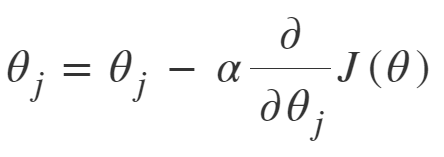


Here, Θ denotes the model parameters, J is the loss function and α is what we call learning rate which is used to specify the strength of the step that we wish to take. A smaller learning rate ensures we do not move away from the minima, but it makes the learning slower, while with a larger learning rate we move quickly towards the minima but are susceptible to overshooting it. Variants of SGD like SGD + Momentum, RMSProp, Adam etc., tries to improve it's noisy nature (which arises due to the fact we work on batches, instead of the entire dataset at a time), by introducing minor modifications to the update equation to prevent the optimizer taking a step in an overly wrong direction, and some also introduce heuristics to decay the step size as we reach closer to the minima. Adam is one of the most used optimizers in Deep Learning applications and often works reasonably well in practical applications. We will use the same for our experiments. You can read more about how these different optimizers work [here](https://cs231n.github.io/neural-networks-3/).

`torch.optim` provides implementations for all of the optimizers we mentioned above. For official documentation for the same, refer [here](https://pytorch.org/docs/stable/optim.html). Below we provide an example on how to define and use optimizers in pytorch



In [55]:
from torch.optim import Adam

torch.manual_seed(42)
# We will first need to define the model
example_model = MultinomialLogisticRegressionModel(d_input = 5, num_labels=3)

# Defining the optimizer
example_optim = Adam(example_model.parameters(), lr = 1e-3)

Notice that the optimizer takes as input two arguments, the first is the parameters (Θ) of the model that are to be learned using the optimizer and the second is the learning rate (α). Adam optimizer also has other hyperparameters like β1 , β2, ϵ, details of which are beyond the scope of this assignment. However, you need not worry about setting these hyper-parameters as in most of the cases the default vaues of these work well enough. Next let's see how to update the model's parameters using the optimizer



In [56]:
example_optim.zero_grad() # This is done to zero-out any existing gradients stored from some previous steps
input = torch.rand(2, 5) # Defining a random input for demonstration
preds = example_model(input)
labels = torch.LongTensor([1,0]) # Defining a random labels for demonstration
loss = loss_fn(preds, labels)
loss.backward() # Perform backward pass
print(f"Parameters before the update: {example_model.linear_layer.weight}")
example_optim.step() # Update the parameters using the optimizer
print(f"Parameters after the update: {example_model.linear_layer.weight}")

Parameters before the update: Parameter containing:
tensor([[ 0.3419,  0.3712, -0.1048,  0.4108, -0.0980],
        [ 0.0902, -0.2177,  0.2626,  0.3942, -0.3281],
        [ 0.3887,  0.0837,  0.3304,  0.0606,  0.2156]], requires_grad=True)
Parameters after the update: Parameter containing:
tensor([[ 0.3429,  0.3702, -0.1038,  0.4118, -0.0970],
        [ 0.0892, -0.2167,  0.2636,  0.3952, -0.3271],
        [ 0.3877,  0.0827,  0.3294,  0.0596,  0.2146]], requires_grad=True)


As you can see after calling `example_optim.step()` the parameters get updated.

### Task 3.3: Training the Model

Now we have all the different components ready and can start training our text classifier. Implement the `train` function below


In [57]:
import torch
import torch.nn as nn
from torch.optim import Adam

def train(model, train_dataloader,
          lr = 1e-3, num_epochs = 20,
          device = "cpu",):

    """
    Runs the training loop

    Inputs:
    - model (MultinomialLogisticRegressionModel): Multinomial Logistic Regression model to be trained
    - train_dataloader (torch.utils.DataLoader): A dataloader defined over the training dataset
    - lr (float): The learning rate for the optimizer
    - num_epochs (int): Number of epochs to train the model for.
    - device (str): Device to train the model on. Can be either 'cuda' (for using gpu) or 'cpu'

    Returns:
    - model (MultinomialLogisticRegressionModel): Model after completing the training
    - epoch_loss (float) : Loss value corresponding to the final epoch
    """

    # Transfer the model to specified device
    model = model.to(device)

    # Step 1: Define the Negative Log Likelihood loss function
    loss_fn =  nn.NLLLoss()

    # Step 2: Define Adam Optimizer
    optimizer = Adam(model.parameters(),lr)

    # Iterate over `num_epochs`
    for epoch in range(num_epochs):
        epoch_loss = 0 # We can use this to keep track of how the loss value changes as we train the model.
        # Iterate over each batch using the `train_dataloader`
        for train_batch in tqdm.tqdm(train_dataloader):
            # Zero out any gradients stored in the previous steps
            optimizer.zero_grad()

            # Unwrap the batch to get features and labels
            features, labels = train_batch

            # Most nn modules and loss functions assume the inputs are of type Float while the labels are expected to be of type Long
            features = features.float()
            labels = labels.long()

            # Transfer the features and labels to device
            features = features.to(device)
            labels = labels.to(device)


            # Step 3: Feed the input features to the model to get predictions
            preds = model(features)

            # Step 4: Compute the loss and perform backward pass
            loss = loss_fn(preds, labels)
            loss.backward()

            # Step 5: Take optimizer step
            optimizer.step()

            # Store loss value for tracking
            epoch_loss += loss.item()

        epoch_loss = epoch_loss / len(train_dataloader)
        print(f"Epoch {epoch} completed.. Average Loss: {epoch_loss}")

    return model, epoch_loss

In [58]:
print("Running Sample Test Cases")

print("Training on just 100 training examples for sanity check")
torch.manual_seed(42)
sample_documents = train_df_preprocessed["news"].values.tolist()[:100]
sample_labels = train_df_preprocessed["label"].values.tolist()[:100]
sample_vocab = create_vocab_w_rare_word_filter(train_documents, threshold=5)
sample_word2idx = get_word_idx_mapping(train_vocab)

sample_dataset = AGNewsDataset(sample_documents,
                            sample_labels,
                            sample_vocab,
                            sample_word2idx)

sample_dataloader = DataLoader(sample_dataset)

sample_lr_model = MultinomialLogisticRegressionModel(d_input = len(sample_vocab), num_labels = NUM_LABELS)

sample_lr_model, loss = train(sample_lr_model, sample_dataloader,
      lr = 1e-2, num_epochs = 10,
      device = "cpu")

expected_loss = 0.007294731960864737
print(f"Final Loss Value: {loss}")
print(f"Expected Loss Value: {expected_loss}")

#assert np.allclose(expected_loss, loss, 1e-3)

Running Sample Test Cases
Training on just 100 training examples for sanity check


100%|██████████| 100/100 [00:01<00:00, 53.09it/s]


Epoch 0 completed.. Average Loss: 1.2567401891946792


100%|██████████| 100/100 [00:01<00:00, 72.17it/s]


Epoch 1 completed.. Average Loss: 0.1165983725944534


100%|██████████| 100/100 [00:01<00:00, 73.75it/s]


Epoch 2 completed.. Average Loss: 0.05093511894345284


100%|██████████| 100/100 [00:01<00:00, 74.70it/s]


Epoch 3 completed.. Average Loss: 0.03182960454374552


100%|██████████| 100/100 [00:01<00:00, 74.95it/s]


Epoch 4 completed.. Average Loss: 0.022293031567241998


100%|██████████| 100/100 [00:01<00:00, 77.12it/s]


Epoch 5 completed.. Average Loss: 0.016676900745369493


100%|██████████| 100/100 [00:01<00:00, 76.75it/s]


Epoch 6 completed.. Average Loss: 0.013032732347492129


100%|██████████| 100/100 [00:01<00:00, 77.40it/s]


Epoch 7 completed.. Average Loss: 0.010508539027068765


100%|██████████| 100/100 [00:01<00:00, 55.57it/s]


Epoch 8 completed.. Average Loss: 0.008675242307363077


100%|██████████| 100/100 [00:01<00:00, 50.67it/s]

Epoch 9 completed.. Average Loss: 0.007294733143644407
Final Loss Value: 0.007294733143644407
Expected Loss Value: 0.007294731960864737


Don't worry if the exact loss values do not match, as long as your loss is reducing with epochs and the final loss is in the same range, you should be fine. And now lets train on the entire dataset, this may take some time, approximate 8 minutes per epoch. So relax and have yourself a cup of coffee while this runs

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"

agnews_lr_model = MultinomialLogisticRegressionModel(
    d_input = len(train_vocab), num_labels=NUM_LABELS
)
agnews_lr_model, final_loss = train(agnews_lr_model, train_dataloader,
      lr = 1e-2, num_epochs = 2,
      device = device)

100%|██████████| 1875/1875 [20:32<00:00,  1.52it/s]


Epoch 0 completed.. Average Loss: 0.31367715898950893


100%|██████████| 1875/1875 [20:25<00:00,  1.53it/s]

Epoch 1 completed.. Average Loss: 0.2210599809328715


### Task 3.4: Evaluating the Model

Evaluation is one of the most important step in a Machine Learning pipeline, as it help us measure how well the trained is able to predict on unseen data. There are different performance metrics that can be used for evaluating machine learning algorithms. One of the most commonly used metrics for evaluating classification models is accuracy which is defined as the number of test examples predicted correctly by the model divided by the total number of test examples.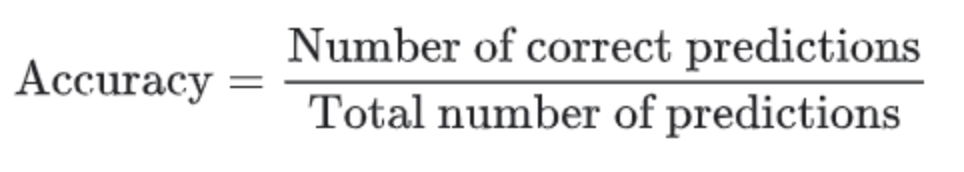

To check the number of correct predictions we can check the label predicted by our model and the actual label for a test example and if they both are the same. However, note that our model outputs log-probabilities for each class and not directly predicts the label. To get that, we can simply select the class as the predicted label which has the highest log probability. We start by implementing `convert_outputs_to_labels` function which does exactly that

In [60]:
def convert_outputs_to_labels(outputs):
    """
    Convert the model's outputs or log-probabilities to labels by using the specified threshold

    Inputs:
    - outputs (numpy.ndarray): A numpy 2d array containing the outputs predicted by the classifier model

    Returns:
    - labels (numpy.ndarray): Labels obtained after thresholding
    - confs (numpy.ndarray): Model's confidence (or probability) for each predicted label

    Hint: np.argmax or np.max can be useful here
    """

    labels = np.argmax(outputs, axis= 1)
    confs = np.max(np.exp(outputs), axis = 1)


    return labels, confs

In [61]:
print("Running Sample Test Cases")

print("Sample Test Case 1")
sample_outs = np.log(np.array([[0.2, 0.7, 0.1], [0.76, 0.2, 0.04], [0.1, 0.2, 0.7], [0.8, 0.1, 0.1]]))
print(f"Input Probabilities: {sample_outs}")
sample_labels, sample_confs = convert_outputs_to_labels(sample_outs)
expected_labels = np.array([1, 0, 2, 0])
expected_confs = np.array([0.7, 0.76, 0.7, 0.8])
print(f"Predicted Lables: {sample_labels}")
print(f"Confidence: {sample_confs}")

print(f"Expected Lables: {expected_labels}")
print(f"Expected Confidence: {expected_confs}")

assert (sample_labels == expected_labels).all()
assert (sample_confs == expected_confs).all()

print("**********************************\n")



Running Sample Test Cases
Sample Test Case 1
Input Probabilities: [[-1.60943791 -0.35667494 -2.30258509]
 [-0.27443685 -1.60943791 -3.21887582]
 [-2.30258509 -1.60943791 -0.35667494]
 [-0.22314355 -2.30258509 -2.30258509]]
Predicted Lables: [1 0 2 0]
Confidence: [0.7  0.76 0.7  0.8 ]
Expected Lables: [1 0 2 0]
Expected Confidence: [0.7  0.76 0.7  0.8 ]
**********************************



Next lets implement the `get_accuracy` function which takes as input predicted labels and actual labels and computes the accuracy

In [62]:
def get_accuracy(pred_labels, act_labels):
    """
    Calculates the accuracy value by comparing predicted labels with actual labels

    Inputs:
    - pred_labels (numpy.ndarray) : A numpy 1d array containing predicted labels.
    - act_labels (numpy.ndarray): A numpy 1d array containing actual labels (of same size as pred_labels).

    Returns:
    - accuracy (float): Number of correct predictions / Total number of predictions

    """
    accuracy = np.sum(pred_labels == act_labels)/len(pred_labels)

    return accuracy

In [63]:
print("Running Sample Test Cases")

print("Sample Test Case 1")
sample_pred_labels = np.array([0, 0, 1, 1])
sample_act_labels = np.array([0, 0, 0, 1])
sample_acc = get_accuracy(sample_pred_labels, sample_act_labels)
expected_acc = 0.75
print(f"Input Predicted Labels: {sample_pred_labels}")
print(f"Input Actual Labels: {sample_act_labels}")
print(f"Accuracy: {sample_acc}")
print(f"Expected Accuracy: {expected_acc}")

assert sample_acc == expected_acc
print("**********************************\n")

print("Sample Test Case 2")
sample_pred_labels = np.array([0, 0, 1, 1, 0])
sample_act_labels = np.array([1, 1, 0, 0, 1])
sample_acc = get_accuracy(sample_pred_labels, sample_act_labels)
expected_acc = 0
print(f"Input Predicted Labels: {sample_pred_labels}")
print(f"Input Actual Labels: {sample_act_labels}")
print(f"Accuracy: {sample_acc}")
print(f"Expected Accuracy: {expected_acc}")

assert sample_acc == expected_acc

print("**********************************\n")


Running Sample Test Cases
Sample Test Case 1
Input Predicted Labels: [0 0 1 1]
Input Actual Labels: [0 0 0 1]
Accuracy: 0.75
Expected Accuracy: 0.75
**********************************

Sample Test Case 2
Input Predicted Labels: [0 0 1 1 0]
Input Actual Labels: [1 1 0 0 1]
Accuracy: 0.0
Expected Accuracy: 0
**********************************



Now we can implement `evaluate` function which takes in a model and a test dataloader, iterates through every batch of the test dataset and calculates the average accuracy.

In [64]:
def evaluate(model, test_dataloader, device = "cpu"):
    """
    Evaluates `model` on test dataset

    Inputs:
    - model (MultinomialLogisticRegressionModel): Logistic Regression model to be evaluated
    - test_dataloader (torch.utils.DataLoader): A dataloader defined over the test dataset

    Returns:
    - accuracy (float): Average accuracy over the test dataset
    - preds (np.ndarray): Predictions of the model on test dataset
    """
    model.to(device)
    model = model.eval() # Set model to evaluation model
    accuracy = 0
    preds = []

    # by specifying `torch.no_grad`, it ensures no gradients are calcuated while running the model,
    # this makes the computation much more faster
    with torch.no_grad():
        for test_batch in tqdm.tqdm(test_dataloader):
            features, labels = test_batch
            features = features.float().to(device)
            labels = labels.float().to(device)

            # Step 1: Get probability predictions from the model and store it in `pred_probs`
            pred_logprobs = model(features)

            # Convert predictions and labels to numpy arrays from torch tensors as they are easier to operate for computing metrics
            pred_logprobs = pred_logprobs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()

            # Step 2: Get accuracy of predictions and store it in `batch_accuracy`
            pred_labels, _ = convert_outputs_to_labels(pred_logprobs)
            batch_accuracy = get_accuracy(pred_labels , labels)

            accuracy += batch_accuracy
            preds += pred_labels.tolist()

    # Divide by number of batches to get average accuracy
    accuracy = accuracy / len(test_dataloader)

    return accuracy, np.array(preds)

In [65]:
print("Running Sample Test Cases")

print("Testing on just 100 test examples for sanity check")
torch.manual_seed(42)
sample_documents = test_df_preprocessed["news"].values.tolist()[:100]
sample_labels = test_df["label"].values.tolist()[:100]

sample_dataset = AGNewsDataset(sample_documents,
                            sample_labels,
                            train_vocab,
                            train_word2idx)

sample_dataloader = DataLoader(sample_dataset, batch_size = 64)

accuracy, _ = evaluate(agnews_lr_model, sample_dataloader, device ="cpu")

expected_accuracy = 0.8680555555555556
print(f"Accuracy: {accuracy}")
print(f"Expected Accuracy: {expected_accuracy}")

#assert np.allclose(expected_accuracy, accuracy, 1e-5)

Running Sample Test Cases
Testing on just 100 test examples for sanity check


100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

Accuracy: 0.8836805555555556
Expected Accuracy: 0.8680555555555556


Again, don't worry if the values do not match exactly. As long as the value you obtained is close to 0.86 it should be fine

Let's obtain the accuracy on the entire test set now

In [66]:
test_acc, test_preds = evaluate(agnews_lr_model, test_dataloader, device = device)
print(f"Test Accuracy: {(100* test_acc).round(2)}%")

100%|██████████| 119/119 [01:18<00:00,  1.52it/s]

Test Accuracy: 89.63%


We obtain around 89.47% accuracy form our logistic regression, which is very reasonable considering random guessing will fetch you an accuracy of ~20%. So we are doing ~70% better than random guessing which is pretty good for our first model.

### Task 3.5: Error Analysis

While it is nice to have a single number (accuracy in this case) that explains the performance of our model, in practice we often need to have more detailed insights into how the model is performing. One of popular methods for visualizing the performance of multi-class classifiers is Confusion Matrix. Each row of a confusion matrix represents the instances in an actual class while each column represents the instances in a predicted class.

![conf_mat](https://miro.medium.com/v2/resize:fit:1400/1*yH2SM0DIUQlEiveK42NnBg.png)

Below we implement the function `get_confusion_matrix` that takes the predictions and labels to construct the confusion matrix

In [ ]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
from sklearn.metrics import confusion_matrix as cm

In [68]:
def get_confusion_matrix(preds, labels):

    """
    Computes confusion matrix from `preds` and `labels`

    Inputs:
        - preds (np.ndarray): Predictions of the model on test dataset
        - labels (np.ndarray): Actual labels of the test dataset

    Returns:
        - confusion_matrix (np.ndarray): A 2d numpy array containing the confusion matrix
    """
    confusion_matrix = cm(labels, preds)
    return confusion_matrix

In [69]:
# Sample Test Case 1
print("Sample Test Case 1")
sample_pred_labels = np.array([0, 0, 1, 1, 0])
sample_act_labels = np.array([1, 1, 0, 0, 1])
sample_confusion_matrix = get_confusion_matrix(sample_pred_labels, sample_act_labels)
expected_confusion_matrix = np.array([[0, 2], [3, 0]])
print(f"Input Predicted Labels: {sample_pred_labels}")
print(f"Input Actual Labels: {sample_act_labels}")
print(f"Confusion Matrix: \n{sample_confusion_matrix}")
print(f"Expected Confusion Matrix: \n{expected_confusion_matrix}")

assert np.allclose(sample_confusion_matrix, expected_confusion_matrix)

print("**********************************\n")

# Sample Test Case 2 (this contains more than 2 classes)
print("Sample Test Case 2")
sample_pred_labels = np.array([0, 0, 1, 1, 0, 2, 2, 2, 2])
sample_act_labels = np.array([1, 1, 0, 0, 1, 2, 2, 2, 2])
sample_confusion_matrix = get_confusion_matrix(sample_pred_labels, sample_act_labels)
expected_confusion_matrix = np.array([[0, 2, 0], [3, 0, 0], [0, 0, 4]])
print(f"Input Predicted Labels: {sample_pred_labels}")
print(f"Input Actual Labels: {sample_act_labels}")
print(f"Confusion Matrix: \n{sample_confusion_matrix}")
print(f"Expected Confusion Matrix: \n{expected_confusion_matrix}")

assert np.allclose(sample_confusion_matrix, expected_confusion_matrix)


Sample Test Case 1
Input Predicted Labels: [0 0 1 1 0]
Input Actual Labels: [1 1 0 0 1]
Confusion Matrix: 
[[0 2]
 [3 0]]
Expected Confusion Matrix: 
[[0 2]
 [3 0]]
**********************************

Sample Test Case 2
Input Predicted Labels: [0 0 1 1 0 2 2 2 2]
Input Actual Labels: [1 1 0 0 1 2 2 2 2]
Confusion Matrix: 
[[0 2 0]
 [3 0 0]
 [0 0 4]]
Expected Confusion Matrix: 
[[0 2 0]
 [3 0 0]
 [0 0 4]]


Now that our implementation of `get_confusion_matrix` looks good, we obtain the confusion matrix for our model's predictions on the test data and analyse the errors

<Axes: >

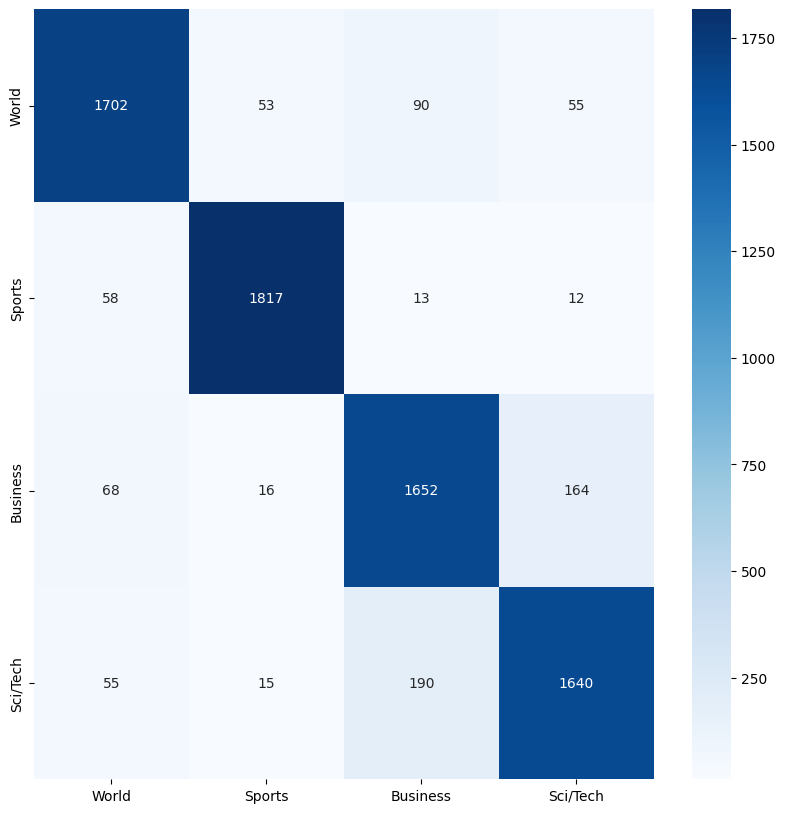

In [70]:
# Get confusion matrix for the test dataset
labels = test_df["label"].values.tolist()
confusion_matrix = get_confusion_matrix(test_preds, labels)

# Plot the confusion matrix using a heatmap in seaborn with LABELS_MAP as labels instead of integers
plt.figure(figsize = (10, 10))
sns.heatmap(confusion_matrix, annot = True, fmt = ".0f", cmap = "Blues", xticklabels = LABELS_MAP, yticklabels = LABELS_MAP)

As can be seen, the most common point of confusion for the model comes from distinguishing Sci/Tech and Business related news.

### Task 3.6: Making Predictions from scratch

Now that we have trained the model and evaluated it's performance it seems like a nice place to end, right? However, one aspect that is often overlooked in ML or NLP pipelines is designing an interface that can make prediction directly on a piece of text using the trained model, abstracting away all the pre-processing and model run details from the user. Let's implement the `predict_document` function below that does exactly that


In [74]:
def predict_document(document, model, train_vocab, train_word2idx, device = "cpu"):
    """
    Predicts the class label for the `document` using `model`

    Inputs:
    - document (str): The document whose news category is to be predicted
    - model (MultinomialLogisticRegressionModel): A trained logistic regression model
    - train_vocab (list): Vocabulary on which the model was trained on
    - train_word2idx (dict): A Python dictionary mapping each word to its index in vocabulary

    Returns:
    - pred_label (str): Predicted topic of the document (shouldn't be an integer but the label's name)
    - confidence (float): Confidence of the prediction

    Hint: Follow the following steps:
    - preprocess the document
    - obtain bag of words features from the preprocessed document
    - convert the features to a pytorch tensor using torch.FloatTensor(features)
    - feed the features tensor to the model to obtain predicted probabilities
    - convert predicted probabilities to labels by checking if predicted probability is greater than or less than the threshold
    """

    model = model.to(device)
    model = model.eval()
    pred_label = None

    #step1: preprocess
    text = preprocess_pipeline(document)

    #step2:  bag of words
    bow = get_document_bow_feature(text, train_vocab, train_word2idx)

    #step3: convert to tensor
    bow = torch.FloatTensor(bow)

    #step4: feeding to model
    preds = model(bow)
    preds = preds.detach().numpy()

    #step5: convert to labels
    pred_label = np.argmax(preds)
    confidence = np.max(np.exp(preds))

    return pred_label, confidence


In [75]:
# Write sample test cases to test a news topic classification model
print("Sample Test Case 1")
sample_document = "India's population to cross China's in 6 years: UN"
sample_pred_label, sample_confidence = predict_document(sample_document, agnews_lr_model, train_vocab, train_word2idx)
expected_pred_label = 0

print(f"Input Document: {sample_document}")
print(f"Predicted Label: {sample_pred_label}")
print(f"Cofidence: {sample_confidence}")
print(f"Expected Predicted Label: {expected_pred_label}")

assert sample_pred_label == expected_pred_label

print("**********************************\n")

print("Sample Test Case 2")
sample_document = "Apple's new iPhone SE for the budget-conscious"
sample_pred_label, sample_confidence = predict_document(sample_document, agnews_lr_model, train_vocab, train_word2idx)
expected_pred_label = 3

print(f"Input Document: {sample_document}")
print(f"Predicted Label: {sample_pred_label}")
print(f"Cofidence: {sample_confidence}")
print(f"Expected Predicted Label: {expected_pred_label}")

assert sample_pred_label == expected_pred_label

print("**********************************\n")

print("Sample Test Case 3")
sample_document = "India's football team captain Sunil Chhetri says he's missing playing"
sample_pred_label, sample_confidence = predict_document(sample_document, agnews_lr_model, train_vocab, train_word2idx)
expected_pred_label = 1

print(f"Input Document: {sample_document}")
print(f"Predicted Label: {sample_pred_label}")
print(f"Cofidence: {sample_confidence}")
print(f"Expected Predicted Label: {expected_pred_label}")

assert sample_pred_label == expected_pred_label

print("**********************************\n")


Sample Test Case 1
Input Document: India's population to cross China's in 6 years: UN
Predicted Label: 0
Cofidence: 0.521279513835907
Expected Predicted Label: 0
**********************************

Sample Test Case 2
Input Document: Apple's new iPhone SE for the budget-conscious
Predicted Label: 3
Cofidence: 0.5553470849990845
Expected Predicted Label: 3
**********************************

Sample Test Case 3
Input Document: India's football team captain Sunil Chhetri says he's missing playing
Predicted Label: 1
Cofidence: 0.6410748362541199
Expected Predicted Label: 1
**********************************



## Bonus Task: Interpreting the trained model

One of the biggest advantages of using linear models like Logistic Regression is that they are much easier to interpret compared to more sophisticated neural network models. We can just look at the weights of a trained logistic regression model and based on that can determine certain interesting insights about the model.

![linear_model_interpretation](https://i.ibb.co/2ZgKJSf/image-6487327.jpg)

As can be seen from the image above we look at the we can just look at the features corresponding the highest values of a row j to find the most important features for the prediction of class j according to our model. Recall that for bag of words each of the feature can be interpreted as a word from the vocabulary. Hence, by just looking at the weights we can figure out the words whose presence is most likely to cause prediction of a particular class. Implement `get_imp_features_for_class` and `interpret_linear_model` below to do this:

In [101]:
def get_imp_features_for_class(weights, cls, train_vocab, topk = 10):

    """
    Get the top-k important features for a given class

    Inputs:
        - weights (ndarray): The weights of the model. Shape: [num_classes, num_features]
        - cls (int): The class for which the top-k important features are to be returned
        - train_vocab (list): Vocabulary on which the model was trained on
        - topk (int): Number of top-k important features to be returned

    Returns:
        - imp_features (list): List of top-k important features for the given class.
            Each element of the list should be a string corresponding to a word in the vocabulary.
        - imp_values (list): List of top-k important feature values for the given class (given by just the value of the weights).

    """


    imp_values = np.sort(weights[cls])[::-1][:10].tolist()

    topk_indices = np.argsort(weights[cls])[::-1][:10]
    imp_features = [train_vocab[x] for x in topk_indices]

    return imp_features, imp_values


def intepret_linear_model(model, train_vocab, topk = 10):

    """
    Interpret the linear model by obtaining the top-k important features for each class

    Inputs:
        - model (MultinomialLogisticRegressionModel): The linear model
        - train_vocab (list): Vocabulary on which the model was trained on
        - topk (int): Number of top-k important features to be returned

    Returns:
        - imp_features (dict): Dictionary of top-k important features with their values for each class.
            The keys of the dictionary are the class labels and the values are dictionaries of the form {"features": imp_features, "values": imp_values}


    Example output:
    {
        "World": {"features": ["world", "said", "tuesday", "wednesday", "thursday", "friday", "monday", "sunday", "year", "new"], "values": [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01]},
        "Sports": {"features": ["said", "game", "year", "team", "games", "tuesday", "wednesday", "thursday", "friday", "monday"], "values": [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01]},
        "Business": {"features": ["said", "company", "business", "tuesday", "wednesday", "thursday", "friday", "monday", "new", "year"], "values": [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01]},
        "Sci/Tech": {"features": ["said", "new", "year", "people", "time", "tuesday", "wednesday", "thursday", "friday", "monday"], "values": [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01]}
    }

    These values were just invented randomly, the only thing you should take-away from the example is the format of the output.

    Hint: Weights of the model can be obtained by accessing `model.linear_layer.weight.data`

    """
    classes = {'World':0,'Sports':1,'Business':2,'Sci/Tech':3}
    imp_features = {}
    weights = model.linear_layer.weight.data.detach().numpy()

    for key in classes:
      features,values = get_imp_features_for_class(weights, classes[key], train_vocab, topk)
      imp_features[key] = {"features":features,"values":values}

    return imp_features

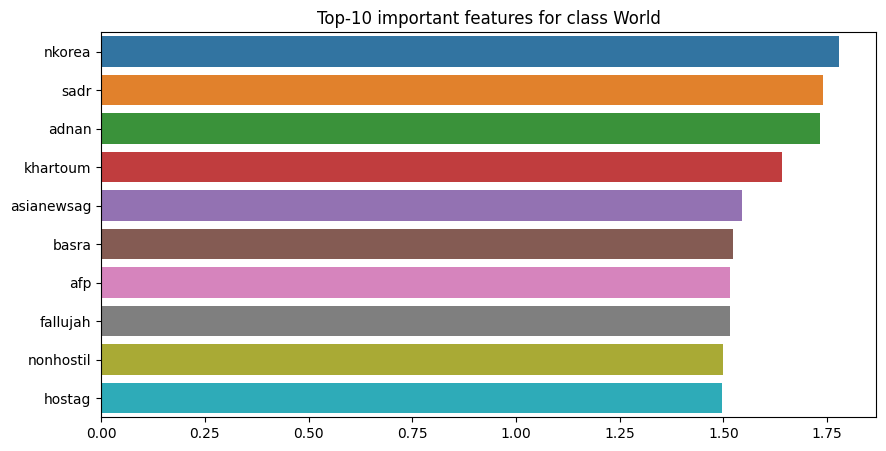

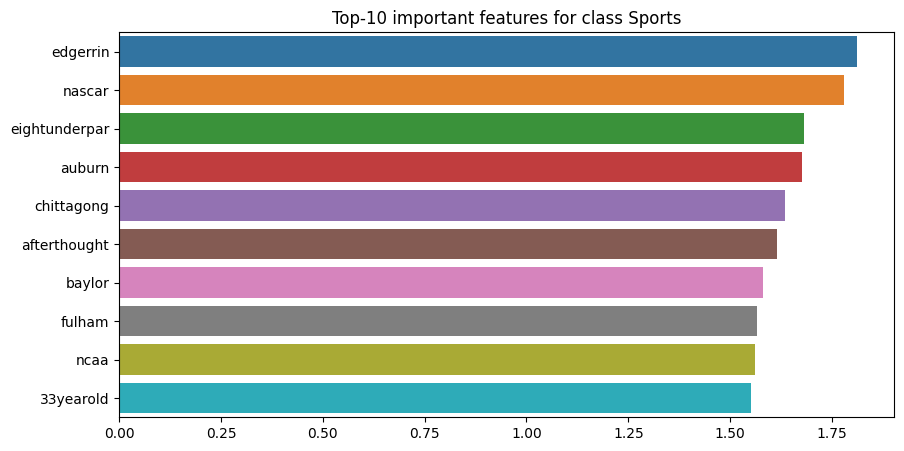

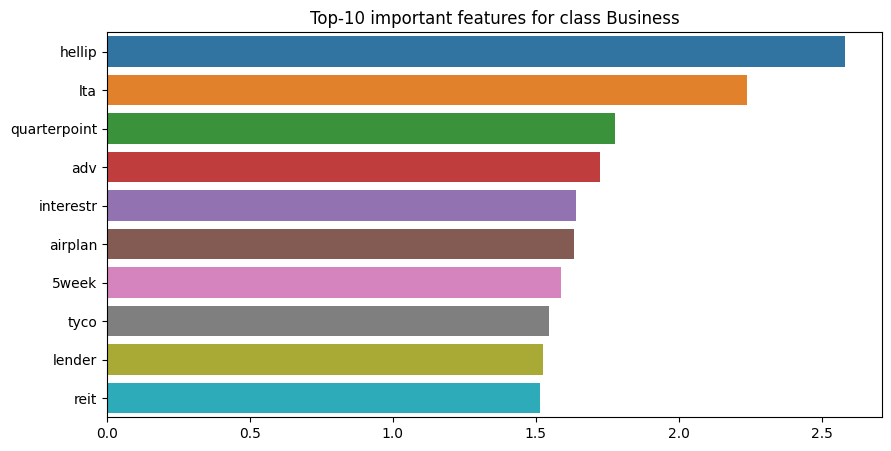

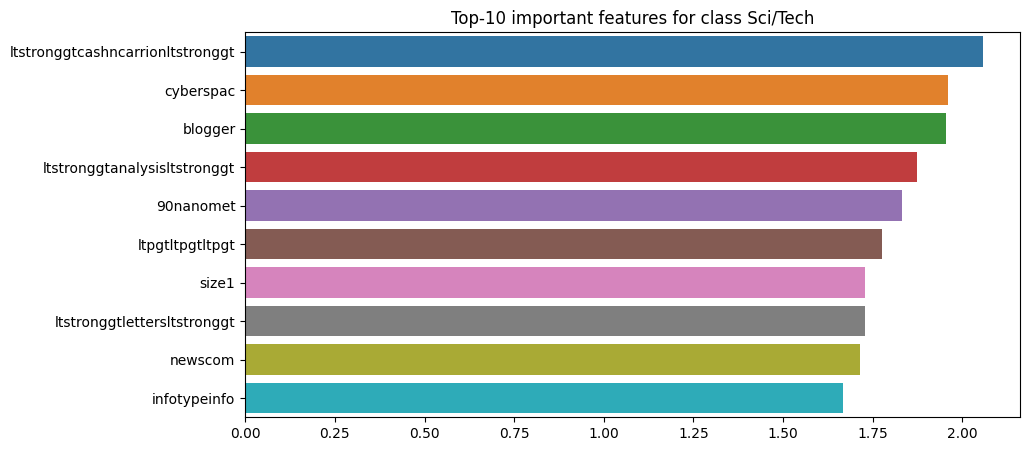

In [102]:
imp_features = intepret_linear_model(agnews_lr_model, train_vocab, topk = 10)

# Visualize the top-k important features for each class using seaborn bar plots

for cls in imp_features:
    plt.figure(figsize = (10, 5))
    sns.barplot(x = imp_features[cls]["values"], y = imp_features[cls]["features"])
    plt.title(f"Top-{10} important features for class {cls}")
    plt.show()

As can be seen we derive insights into how the model classifies the sentences.